In [1]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import random
import time
import glob
import argparse
sys.path.append('../')

# load torch modules
import torch
import torch.nn as nn
import torch.nn.functional as F

# load custom modules required for jetCLR training
from scripts.modules.jet_augs import rotate_jets, distort_jets, rescale_pts, crop_jets, translate_jets, collinear_fill_jets
from scripts.modules.transformer import Transformer
from scripts.modules.losses import contrastive_loss, align_loss, uniform_loss

In [12]:
def return_time():
    time1 = time.time()
    time.sleep(2)
    time2 = time.time()
    time.sleep(2)
    time3 = time.time()
    times = [time1, time2, time3]
    return times

In [13]:
times = return_time()
time1, time2, time3 = times

In [17]:
time2 - time1

2.002039909362793

In [18]:
time3 - time2

2.001366376876831

In [2]:
def load_data(dataset_path, full_kinematics, flag, n_files=-1):
    if full_kinematics:
        data_files = glob.glob(f"{dataset_path}/{flag}/processed/7_features_raw/data/*")
    else:
        data_files = glob.glob(f"{dataset_path}/{flag}/processed/3_features_raw/data/*")

    data = []
    for i, file in enumerate(data_files):
        if full_kinematics:
            data.append(np.load(f"{dataset_path}/{flag}/processed/7_features_raw/data/data_{i}.npy")) 
        else:
            data.append(
                torch.load(
                    f"{dataset_path}/{flag}/processed/3_features_raw/data/data_{i}.pt"
                ).numpy()
            )
        print(f"--- loaded file {i} from `{flag}` directory")
        if n_files != -1 and i == n_files - 1:
            break

    return data


def load_labels(dataset_path, full_kinematics, flag, n_files=-1):
    if full_kinematics:
        data_files = glob.glob(f"{dataset_path}/{flag}/processed/7_features_rawlabels/*")
    else:
        data_files = glob.glob(f"{dataset_path}/{flag}/processed/3_features_raw/labels/*")

    data = []
    for i, file in enumerate(data_files):
        if full_kinematics:
            data.append(np.load(f"{dataset_path}/{flag}/processed/7_features_raw/labels/labels_{i}.npy")) 
        else:
            data.append(
                torch.load(
                    f"{dataset_path}/{flag}/processed/3_features_raw/labels/labels_{i}.pt"
                ).numpy()
            )
        print(f"--- loaded label file {i} from `{flag}` directory")
        if n_files != -1 and i == n_files - 1:
            break

    return data

In [3]:
parser = argparse.ArgumentParser()
args = parser.parse_args(args=[])

In [4]:
args.ptd = True
args.cf = True
args.rot = True
args.trs = True
args.mask = True
args.cmask = False
args.trsw = 1.0
args.ptst = 0.1
args.ptcm = 0.1
args.num_files = 1

## Load data

In [5]:
print( "loading data")
data_7 = load_data("/ssl-jet-vol-v2/toptagging", True, "test", 1)
# labels_7 = load_labels("/ssl-jet-vol-v2/toptagging", True, "test", 1)
data_3 = load_data("/ssl-jet-vol-v2/toptagging", False, "test", 1)
labels_3 = load_labels("/ssl-jet-vol-v2/toptagging", False, "test", 1)
data_7 = np.concatenate(data_7, axis=0)  # Concatenate along the first axis
# labels_7 = np.concatenate(labels_7, axis=0)
data_3 = np.concatenate(data_3, axis=0)  # Concatenate along the first axis
labels_3 = np.concatenate(labels_3, axis=0)
# data_3 = data_3[:, [1,2,0], :] # eta, phi, pT

loading data
--- loaded file 0 from `test` directory
--- loaded file 0 from `test` directory
--- loaded label file 0 from `test` directory


In [6]:
print(data_7.shape)
print(data_3.shape)
print(labels_3.shape)

(100001, 7, 50)
(100001, 3, 50)
(100001,)


In [7]:
data_6 = data_7[:, :6, :]
data_6.shape

(100001, 6, 50)

In [31]:
data_3_logpt = np.copy(data_3[:, [1,2,0], :])
pT = data_3[:, 0, :]
log_pT = np.where(pT != 0, np.log(pT), 0)
data_3_logpt[:, 2, :] = log_pT
data_3_logpt[10, 2, :20]

/tmp/ipykernel_69/2679451373.py:3: RuntimeWarning: divide by zero encountered in log
  log_pT = np.where(pT != 0, np.log(pT), 0)


array([5.571498 , 4.810458 , 3.5153518, 3.371008 , 3.3604524, 3.3254285,
       2.8889947, 2.7061505, 2.6781998, 2.1596396, 2.1304286, 1.8763572,
       1.8212461, 1.7756172, 1.7694325, 1.6454159, 1.6450348, 1.3756193,
       1.331456 , 1.0708727], dtype=float32)

In [9]:
data_3[0, 2, :20]

array([2.5729783, 2.4447327, 2.4571295, 2.456231 , 2.4446878, 2.4510114,
       1.8226271, 2.4571872, 2.4165747, 2.524141 , 2.393815 , 2.3535652,
       2.442851 , 1.9454399, 2.6713982, 2.277823 , 2.9871058, 0.       ,
       0.       , 0.       ], dtype=float32)

In [10]:
save_path = "../plots/examine-augmentations"
os.system(f"mkdir -p {save_path}")  # -p: create parent dirs if needed, exist_ok

0

In [11]:
"""
The 7 input features per particle in the jet.
    1. ∆η difference in pseudorapidity between the particle and the jet axis
    2. ∆φ difference in azimuthal angle between the particle and the jet axis
    3. log pT logarithm of the particle’s pT
    4. log E logarithm of the particle’s energy
    5. log pT/pT_jet logarithm of the particle’s pT relative to the jet pT
    6. log E/E_jet logarithm of the particle’s energy relative to the jet energy
    7. ∆R
"""

feature_dict = {
    "eta": 0,
    "phi": 1,
    "pt": 2,
    "E": 3,
    "pt/jet_pt": 4,
    "E/jet_E": 5,
    "deltaR": 6,    
}

feature_label = {
    "eta": r"Particle $\left| \eta \right|$",
    "phi": r"Particle $\left| \phi \right|$",
    "pt": r"Particle log $p_T$",
    "E": "Particle E",
    "pt/jet_pt": r"Log($\frac{p_T(particle)}{p_T(jet)})$",
    "E/jet_E": r"$Log(\frac{E(particle)}{E(jet)})$",
    "deltaR": r"$\Delta R(particle, jet)$", 
    
}

In [36]:
data_7.shape

(100001, 7, 50)

In [33]:
data_3_logpt.shape

(100001, 3, 50)

feature pt corresponding to index 2


100001it [00:02, 42213.46it/s]
100001it [00:12, 8203.45it/s]


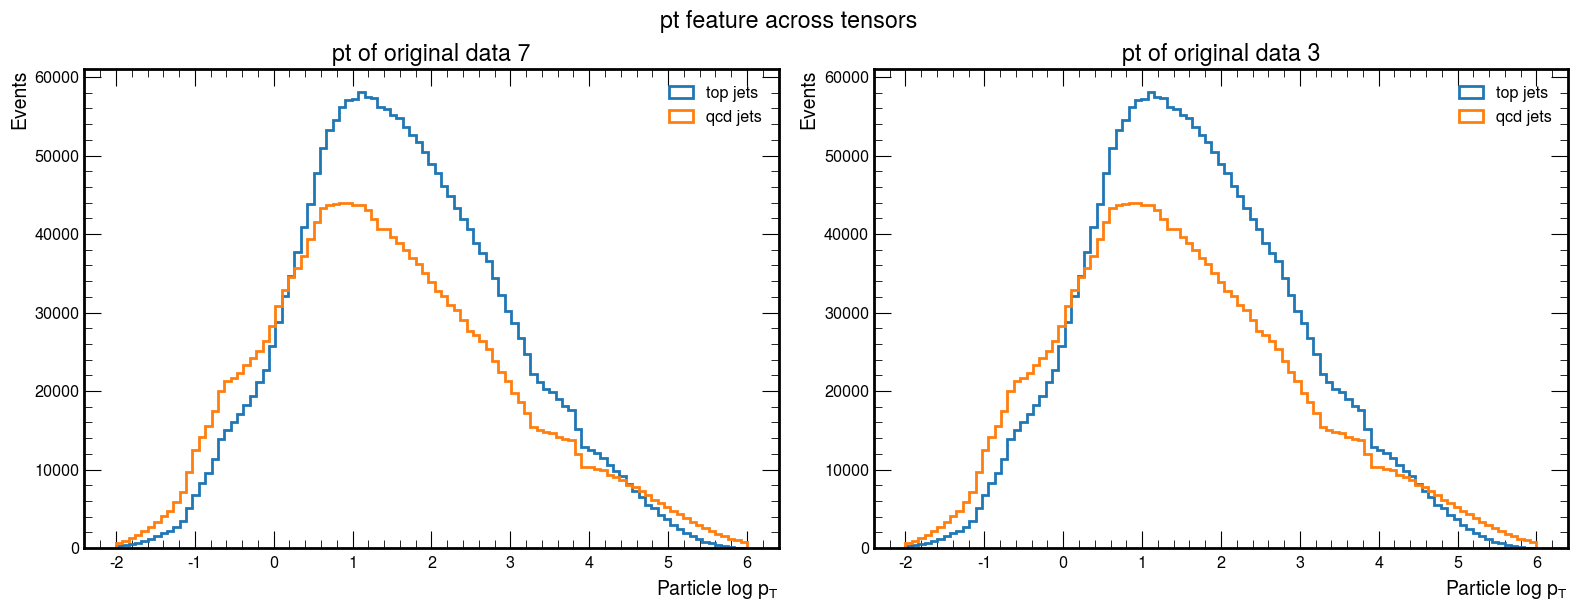

feature eta corresponding to index 0


100001it [00:06, 14566.65it/s]
100001it [00:16, 6024.18it/s]


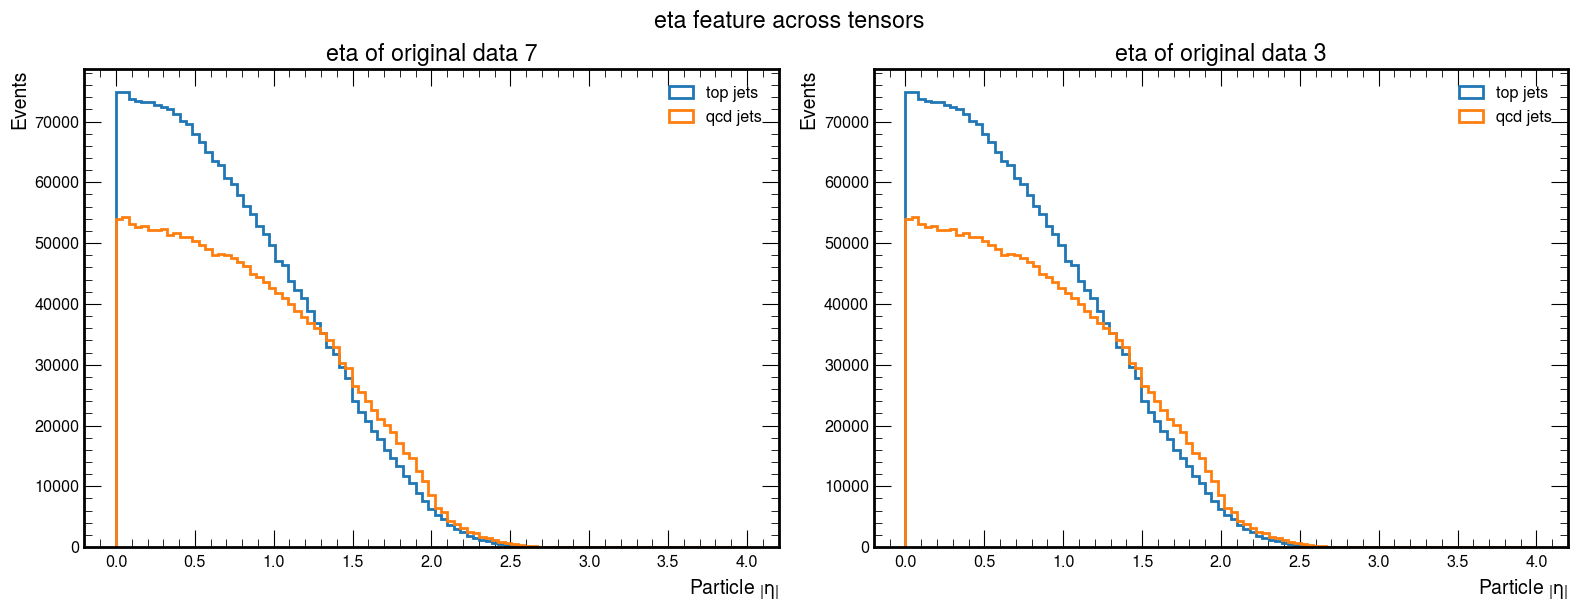

feature phi corresponding to index 1


5528it [00:00, 14423.00it/s]


KeyboardInterrupt: 

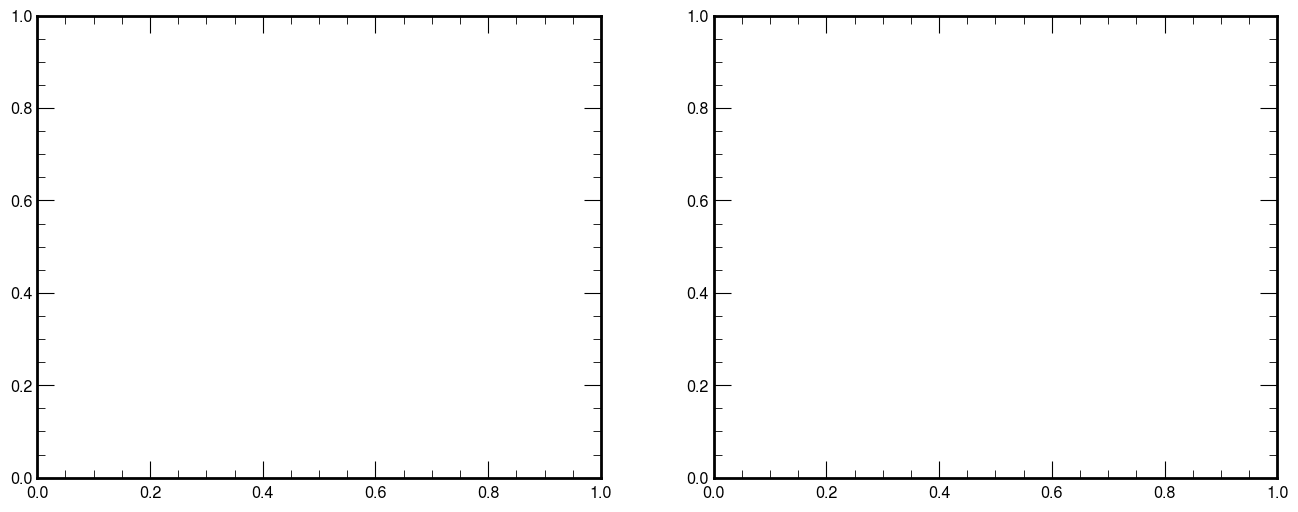

In [38]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

# Features to look at and their corresponding indices
features_to_plot = ['pt', 'eta', 'phi']
tensor_names = ['original data 7', 'original data 3']
tensors = [data_7, data_3_logpt]
labels = labels_3  # Using the same labels tensor for all four tensors

# Set plot parameters
plt.rcParams.update({'font.size': 14})

# Iterate over each feature to create separate 2x2 plots
for feature in features_to_plot:
    index = feature_dict[feature]
    print(f"feature {feature} corresponding to index {index}")
    
    # Prepare the figure for the current feature
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    axes = axes.flatten()
    
    # Iterate over each tensor and plot
    for i, (tensor, tensor_name) in enumerate(zip(tensors, tensor_names)):
        features = {'top': [], 'qcd': []}
        
        # Collect features based on labels
        for jet, class_label in tqdm(zip(tensor, labels)):
            if class_label == 1:
                label = 'top'
            else:
                label = 'qcd'
            
            for particle in jet.T:
                if particle[index] != 0:
                    if feature == 'pt':
                        features[label].append(particle[index])
                    else:
                        features[label].append(np.abs(particle[index]))
        
        # Plot histograms for the current feature
        ax = axes[i]
        start, end = 0, 4 # plotting range
        if feature == "pt":
            start, end = -2, 6
        ax.hist(features['top'], bins=np.linspace(start, end, 100), histtype='step', linewidth=2, label=f"top jets")
        ax.hist(features['qcd'], bins=np.linspace(start, end, 100), histtype='step', linewidth=2, label=f"qcd jets")
        
        # Set labels and title for the subplot
        ax.legend()
        ax.set_xlabel(feature_label[feature]);
        ax.set_ylabel(r"Events"); 
        ax.set_title(f"{feature} of {tensor_name}")

    # Adjust layout and show/save the plot for the current feature
    plt.tight_layout()
    plt.suptitle(f"{feature} feature across tensors", y=1.02)
#     plt.savefig(f"{save_path}/{feature}_input_data_comparison.png", bbox_inches='tight', dpi=300)
    plt.show()

## Define the two augmentation functions

In [39]:
def augmentation_new(x_i, full_kinematics, device, return_3=False):
    """
    Applies all the augmentations specified in the args
    """
    # x_i has shape (batch_size, 7, n_constit)
    # dim 1 ordering: 'part_deta','part_dphi','part_pt_log', 'part_e_log', 'part_logptrel', 'part_logerel','part_deltaR'
    # extract the (pT, eta, phi) features for augmentations
    if full_kinematics:
        # x_i has shape (batch_size, 7, n_constit)
        # dim 1 ordering: 'part_deta','part_dphi','part_pt_log', 'part_e_log', 'part_logptrel', 'part_logerel','part_deltaR'
        # extract the (pT, eta, phi) features for augmentations
        log_pT = x_i[:, 2, :]
        pT = np.where(log_pT != 0, np.exp(log_pT), 0)
        eta = x_i[:, 0, :]
        phi = x_i[:, 1, :]
        x_i = np.stack([pT, eta, phi], 1)  # (batch_size, 3, n_constit)
#         print(x_i.shape)
#         print(f"eta before augmentation: {x_i[0, 1, :]}")
#         print(f"pt before augmentation: {x_i[0, 0, :]}")
    time1 = time.time()
#     print(f"eta before augmentation: {x_i[0, 1, :]}")
    x_i = rotate_jets(x_i)
#     print(f"eta after rotation: {x_i[0, 1, :]}")
    x_j = x_i.copy()
    if args.rot:
        x_j = rotate_jets(x_j)
    time2 = time.time()
    if args.cf:
        x_j = collinear_fill_jets(x_j)
        x_j = collinear_fill_jets(x_j)
    time3 = time.time()
    if args.ptd:
        x_j = distort_jets(x_j, strength=args.ptst, pT_clip_min=args.ptcm)
    time4 = time.time()
    if args.trs:
        x_j = translate_jets(x_j, width=args.trsw)
        x_i = translate_jets(x_i, width=args.trsw)
#     print(f"eta after translation: {x_i[0, 1, :]}")
    time5 = time.time()
#     x_i = rescale_pts(x_i)
# #     print(f"eta after rescaling: {x_i[0, 1, :]}")
    x_j = rescale_pts(x_j)
    #   TODO: delete the following two lines before adding back to main code
    x_i = x_i[:, [1, 2, 0], :] # (pT, eta, phi) -> (eta, phi, pT)
    x_j = x_j[:, [1, 2, 0], :]
    if return_3:
        x_i = torch.Tensor(x_i).transpose(1, 2).to(device)
        x_j = torch.Tensor(x_j).transpose(1, 2).to(device)
        return x_i, x_j
#     x_i_3 = torch.Tensor(x_i).transpose(1, 2).to(device)
#     x_j_3 = torch.Tensor(x_j).transpose(1, 2).to(device)
#     print(f"eta after augmentation: {torch.Tensor(x_i[:, 0, :])}")
    if full_kinematics:
        # recalculate the rest of the features after augmentation
        pT_i = x_i[:, 2, :]
        eta_i = x_i[:, 0, :]
#         print(f"eta after extraction: {torch.Tensor(eta_i)}")
        phi_i = x_i[:, 1, :]
        pT_j = x_j[:, 2, :]
        eta_j = x_j[:, 0, :]
        phi_j = x_j[:, 1, :]
        # calculate the rest of the features
        # pT
        pT_log_i = np.where(pT_i != 0, np.log(pT_i), 0)
        pT_log_i = np.nan_to_num(pT_log_i, nan=0.0)
        pT_log_j = np.where(pT_j != 0, np.log(pT_j), 0)
        pT_log_j = np.nan_to_num(pT_log_j, nan=0.0)
        # pTrel
        pT_sum_i = np.sum(pT_i, axis=-1, keepdims=True)
        pT_sum_j = np.sum(pT_j, axis=-1, keepdims=True)
        pt_rel_i = pT_i / pT_sum_i
        pt_rel_j = pT_j / pT_sum_j
        pt_rel_log_i = np.where(pt_rel_i != 0, np.log(pt_rel_i), 0)
        pt_rel_log_i = np.nan_to_num(pt_rel_log_i, nan=0.0)
        pt_rel_log_j = np.where(pt_rel_j != 0, np.log(pt_rel_j), 0)
        pt_rel_log_j = np.nan_to_num(pt_rel_log_j, nan=0.0)
        # E
        E_i = pT_i * np.cosh(eta_i)
        E_j = pT_j * np.cosh(eta_j)
        E_log_i = np.where(E_i != 0, np.log(E_i), 0)
        E_log_i = np.nan_to_num(E_log_i, nan=0.0)
        E_log_j = np.where(E_j != 0, np.log(E_j), 0)
        E_log_j = np.nan_to_num(E_log_j, nan=0.0)
        # Erel
        E_sum_i = np.sum(E_i, axis=-1, keepdims=True)
        E_sum_j = np.sum(E_j, axis=-1, keepdims=True)
        E_rel_i = E_i / E_sum_i
        E_rel_j = E_j / E_sum_j
        E_rel_log_i = np.where(E_rel_i != 0, np.log(E_rel_i), 0)
        E_rel_log_i = np.nan_to_num(E_rel_log_i, nan=0.0)
        E_rel_log_j = np.where(E_rel_j != 0, np.log(E_rel_j), 0)
        E_rel_log_j = np.nan_to_num(E_rel_log_j, nan=0.0)
        # deltaR
        deltaR_i = np.sqrt(np.square(eta_i) + np.square(phi_i))
        deltaR_j = np.sqrt(np.square(eta_j) + np.square(phi_j))
        # stack them to obtain the final augmented data
        x_i = np.stack(
            [
                eta_i,
                phi_i,
                pT_log_i,
                E_log_i,
                pt_rel_log_i,
                E_rel_log_i,
                deltaR_i,
            ],
            1,
        )  # (batch_size, 7, n_constit)
        x_j = np.stack(
            [
                eta_j,
                phi_j,
                pT_log_j,
                E_log_j,
                pt_rel_log_j,
                E_rel_log_j,
                deltaR_j,
            ],
            1,
        )  # (batch_size, 7, n_constit)
#         print(f"eta after recalculation of features: {torch.Tensor(eta_i)}")
    x_i = torch.Tensor(x_i).transpose(1, 2).to(device)
    x_j = torch.Tensor(x_j).transpose(1, 2).to(device)
#     print(f"eta after everything: {x_i[:, :, 0]}")
    return x_i, x_j

In [40]:
def augmentation_old(x_i, device):
    # x_i has shape (batch_size, 3, n_constit)
    # dim 1 ordering: pT, eta, phi
    x_i = rotate_jets(x_i)
    x_j = x_i.copy()
    if args.rot:
        x_j = rotate_jets(x_j)
    time2 = time.time()
    if args.cf:
        x_j = collinear_fill_jets(x_j)
        x_j = collinear_fill_jets(x_j)
    time3 = time.time()
    if args.ptd:
        x_j = distort_jets(x_j, strength=args.ptst, pT_clip_min=args.ptcm)
    time4 = time.time()
    if args.trs:
        x_j = translate_jets(x_j, width=args.trsw)
        x_i = translate_jets(x_i, width=args.trsw)
    time5 = time.time()
#     x_i = rescale_pts(x_i)
#     x_j = rescale_pts(x_j)
    x_i = torch.Tensor(x_i).transpose(1, 2).to(device)
    x_j = torch.Tensor(x_j).transpose(1, 2).to(device)
#   TODO: delete the following two lines before adding back to main code
    x_i = x_i[:, :, [1, 2, 0]] # (pT, eta, phi) -> (eta, phi, pT)
    x_j = x_j[:, :, [1, 2, 0]]
#     print(f"eta after old augmentation: {x_i[0, :, 0]}")
    return x_i, x_j

In [15]:
small_data = data_7[:100, :, :]

In [16]:
small_data.shape

(100, 7, 50)

In [17]:
# small_data_aug_i, small_data_aug_j, small_data_aug_i_3, small_data_aug_j_3 = augmentation_new(small_data, True, "cpu")

In [18]:
# (small_data_aug_i[:, :, :2] - small_data_aug_i_3[:, :, :2] < 1e-3).all()

In [19]:
# ind = 5
# small_data_aug_i[:ind, :10, 2]

In [20]:
# np.log(small_data_aug_i_3[:ind, :10, 2])

In [41]:
aug_new_3_i, aug_new_3_j = augmentation_new(data_3, False, "cpu")

In [42]:
aug_new_7_i, aug_new_7_j = augmentation_new(data_7, True, "cpu")

/tmp/ipykernel_69/3388572164.py:64: RuntimeWarning: divide by zero encountered in log
  pT_log_i = np.where(pT_i != 0, np.log(pT_i), 0)
/tmp/ipykernel_69/3388572164.py:66: RuntimeWarning: divide by zero encountered in log
  pT_log_j = np.where(pT_j != 0, np.log(pT_j), 0)
/tmp/ipykernel_69/3388572164.py:73: RuntimeWarning: divide by zero encountered in log
  pt_rel_log_i = np.where(pt_rel_i != 0, np.log(pt_rel_i), 0)
/tmp/ipykernel_69/3388572164.py:75: RuntimeWarning: divide by zero encountered in log
  pt_rel_log_j = np.where(pt_rel_j != 0, np.log(pt_rel_j), 0)
/tmp/ipykernel_69/3388572164.py:80: RuntimeWarning: divide by zero encountered in log
  E_log_i = np.where(E_i != 0, np.log(E_i), 0)
/tmp/ipykernel_69/3388572164.py:82: RuntimeWarning: divide by zero encountered in log
  E_log_j = np.where(E_j != 0, np.log(E_j), 0)
/tmp/ipykernel_69/3388572164.py:89: RuntimeWarning: divide by zero encountered in log
  E_rel_log_i = np.where(E_rel_i != 0, np.log(E_rel_i), 0)
/tmp/ipykernel_69/338

In [43]:
aug_old_3_i, aug_old_3_j = augmentation_old(data_3, "cpu")

In [51]:
np.isinf(aug_new_7_j).any()

tensor(0, dtype=torch.uint8)

In [25]:
print(f"aug_new_3_i shape: {aug_new_3_i.shape}")
print(f"aug_new_3_j shape: {aug_new_3_j.shape}")
print(f"aug_new_7_i shape: {aug_new_7_i.shape}")
print(f"aug_new_7_j shape: {aug_new_7_j.shape}")
print(f"aug_old_3_i shape: {aug_old_3_i.shape}")
print(f"aug_old_3_j shape: {aug_old_3_j.shape}")

aug_new_3_i shape: torch.Size([100001, 50, 3])
aug_new_3_j shape: torch.Size([100001, 50, 3])
aug_new_7_i shape: torch.Size([100001, 50, 7])
aug_new_7_j shape: torch.Size([100001, 50, 7])
aug_old_3_i shape: torch.Size([100001, 50, 3])
aug_old_3_j shape: torch.Size([100001, 50, 3])


## Visualize augmented jets

In [26]:
from tqdm.notebook import tqdm
import mplhep as hep
plt.style.use(hep.style.CMS)
plt.rcParams.update({"font.size": 20})

In [27]:
for tensor in [aug_old_3_i, data_7, aug_new_3_i, aug_new_7_i]:
    print(tensor.shape)

torch.Size([100001, 50, 3])
(100001, 7, 50)
torch.Size([100001, 50, 3])
torch.Size([100001, 50, 7])


feature pt corresponding to index 2


10000it [00:10, 937.00it/s]
10000it [00:05, 1789.13it/s]
10000it [00:09, 1014.96it/s]
10000it [00:05, 1866.44it/s]


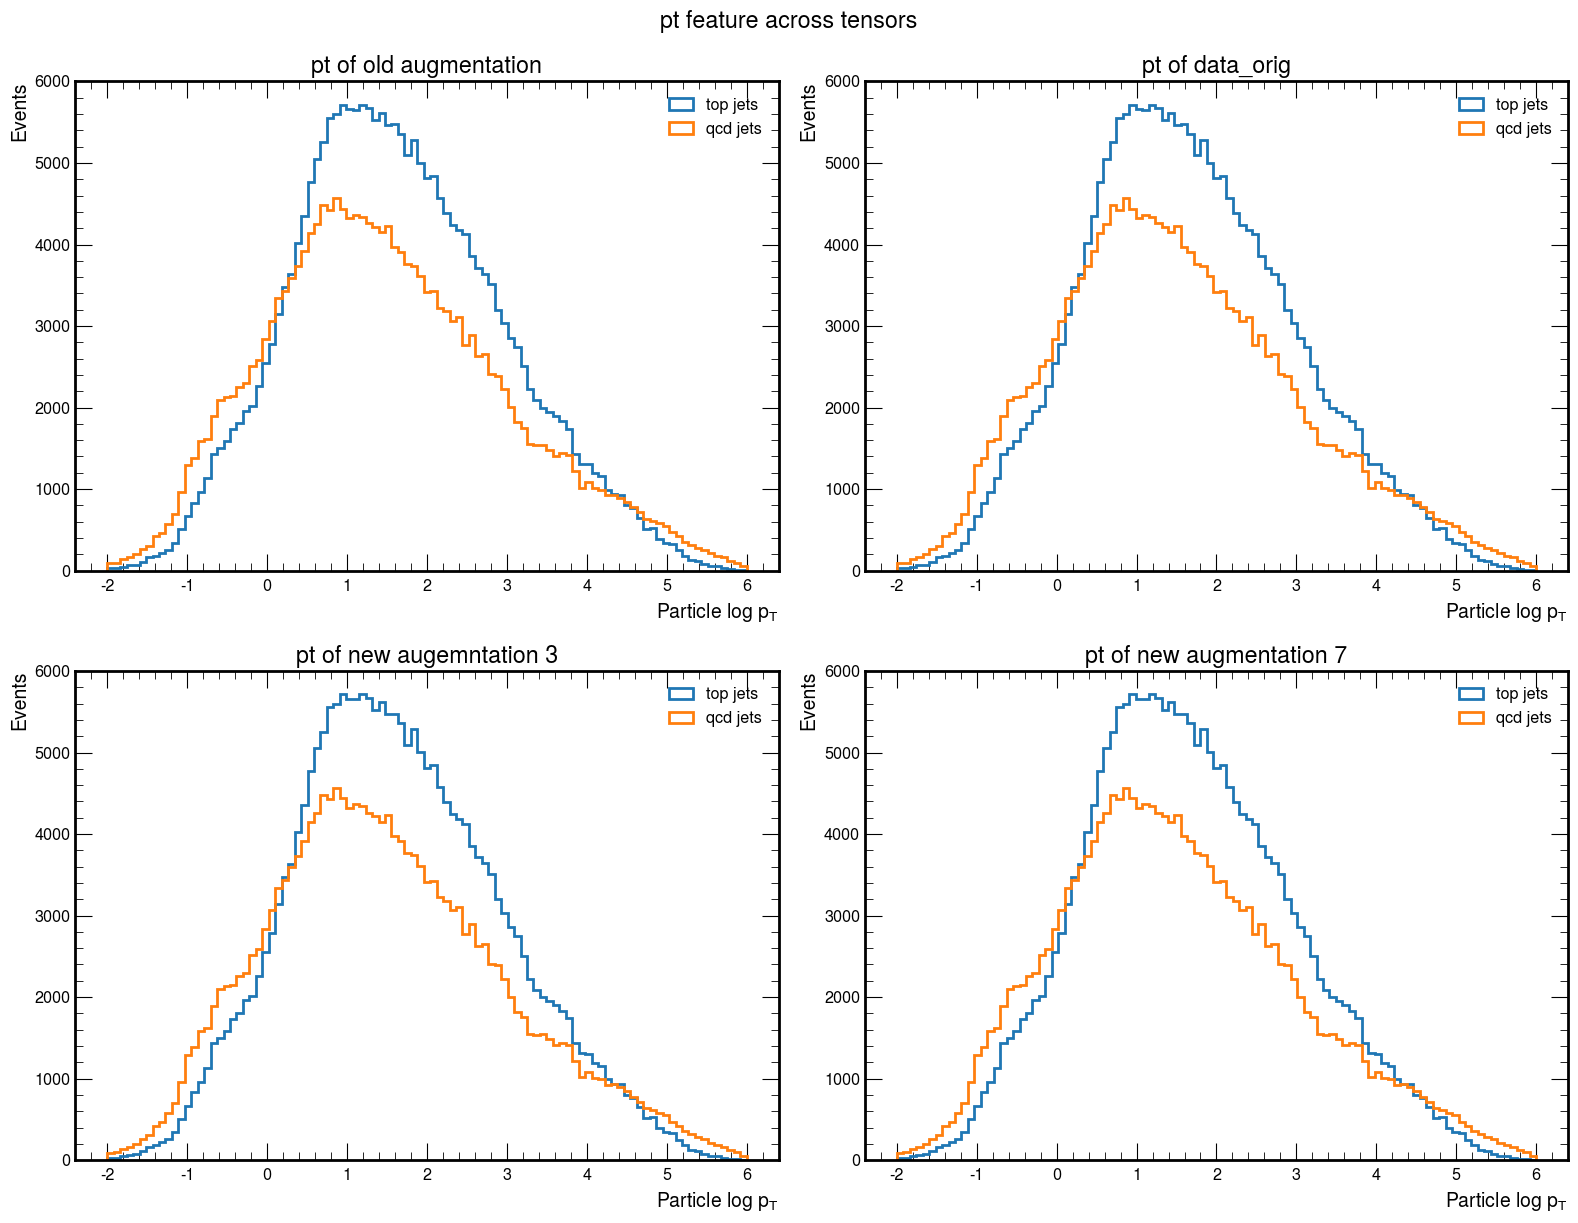

feature eta corresponding to index 0


10000it [00:10, 981.90it/s]
10000it [00:10, 984.68it/s]
10000it [00:10, 988.37it/s]
10000it [00:10, 931.44it/s]


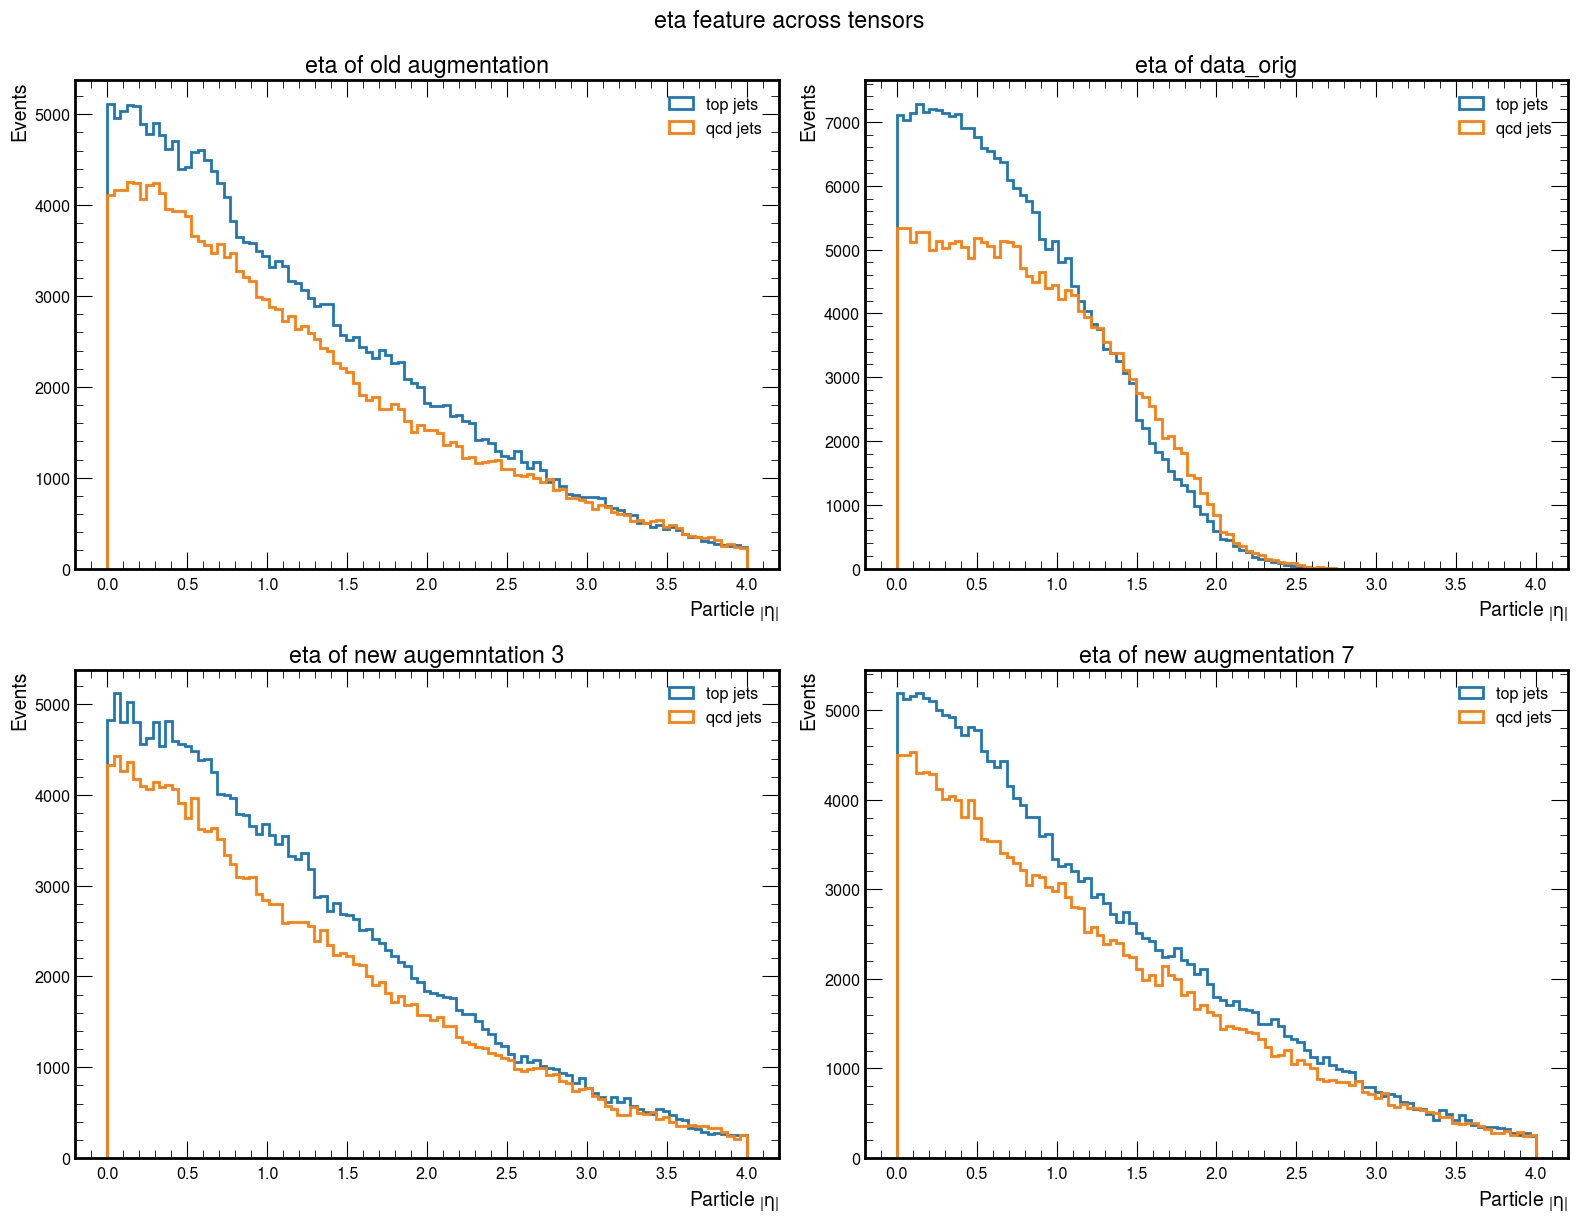

feature phi corresponding to index 1


10000it [00:10, 946.17it/s]
10000it [00:10, 999.64it/s]
10000it [00:10, 945.64it/s]
10000it [00:10, 933.99it/s]


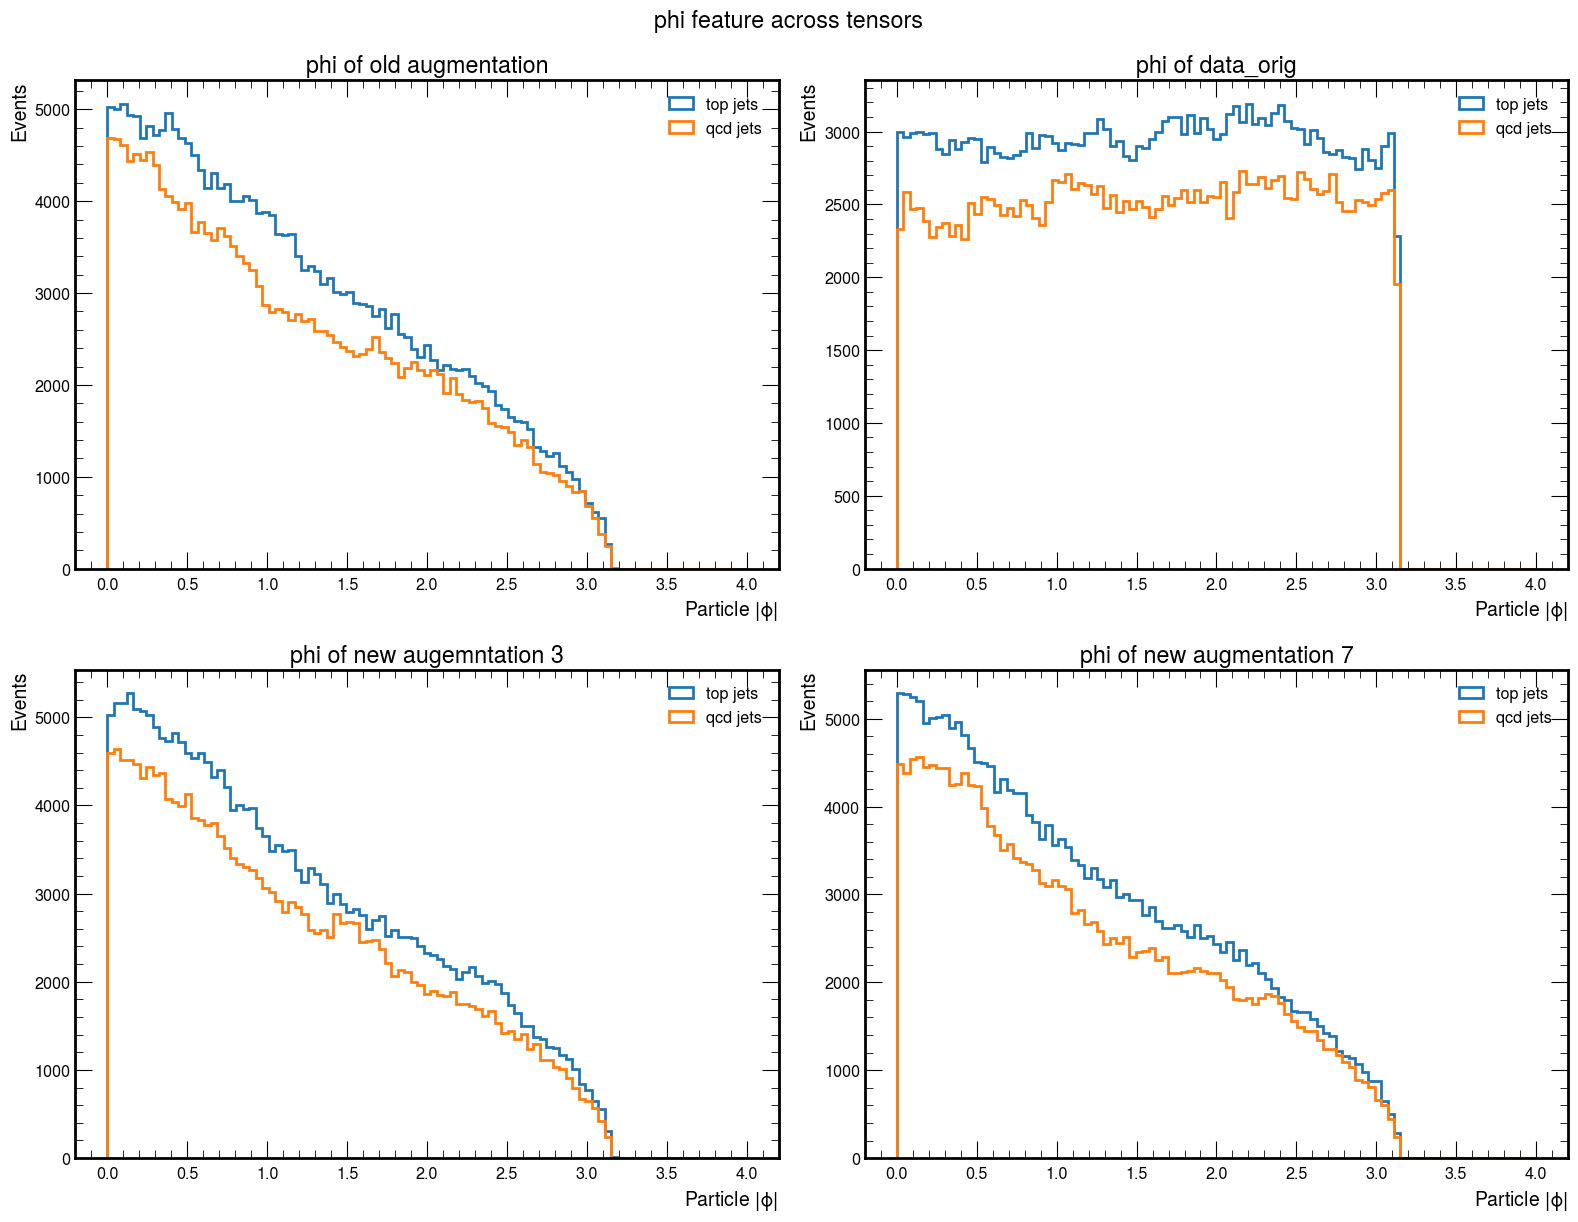

In [44]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

# Features to look at and their corresponding indices
feature_dict = {'pt': 2, 'eta': 0, 'phi': 1}  # Replace with actual indices
features_to_plot = ['pt', 'eta', 'phi']
tensor_names = ['old augmentation', 'data_orig', 'new augemntation 3', 'new augmentation 7']
# tensors = [aug_old_3_i, torch.Tensor(data_7).transpose(1,2), aug_new_3_i, aug_new_7_i]
tensors = [aug_old_3_i[:10000], torch.Tensor(data_7).transpose(1,2)[:10000], aug_new_3_i[:10000], aug_new_7_i[:10000]]
labels = labels_3  # Using the same labels tensor for all four tensors

# Set plot parameters
plt.rcParams.update({'font.size': 14})

# Iterate over each feature to create separate 2x2 plots
for feature in features_to_plot:
    index = feature_dict[feature]
    print(f"feature {feature} corresponding to index {index}")
    
    # Prepare the figure for the current feature
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    axes = axes.flatten()
    
    # Iterate over each tensor and plot
    for i, (tensor, tensor_name) in enumerate(zip(tensors, tensor_names)):
        features = {'top': [], 'qcd': []}
        
        # Collect features based on labels
        for jet, class_label in tqdm(zip(tensor, labels)):
            if class_label == 1:
                label = 'top'
            else:
                label = 'qcd'
            
            for particle in jet:
                if particle[index] != 0:
                    if feature == 'pt':
                        if tensor_name in ['old augmentation', 'new augemntation 3']:
                            features[label].append(np.log(particle[index]))
                        else:
                            features[label].append(particle[index])
                    else:
                        features[label].append(np.abs(particle[index]))
        
        # Plot histograms for the current feature
        ax = axes[i]
        start, end = 0, 4 # plotting range
        if feature == "pt":
            start, end = -2, 6
        ax.hist(features['top'], bins=np.linspace(start, end, 100), histtype='step', linewidth=2, label=f"top jets")
        ax.hist(features['qcd'], bins=np.linspace(start, end, 100), histtype='step', linewidth=2, label=f"qcd jets")
        
        # Set labels and title for the subplot
        ax.legend()
        ax.set_xlabel(feature_label[feature]);
        ax.set_ylabel(r"Events"); 
        ax.set_title(f"{feature} of {tensor_name}")

    # Adjust layout and show/save the plot for the current feature
    plt.tight_layout()
    plt.suptitle(f"{feature} feature across tensors", y=1.02)
    plt.savefig(f"{save_path}/{feature}_feature_comparison_no_rescale_i.png", bbox_inches='tight', dpi=300)
    plt.show()

feature pt corresponding to index 2


10000it [00:11, 868.75it/s]
10000it [00:05, 1903.27it/s]
10000it [00:11, 900.82it/s]
10000it [00:05, 1684.71it/s]


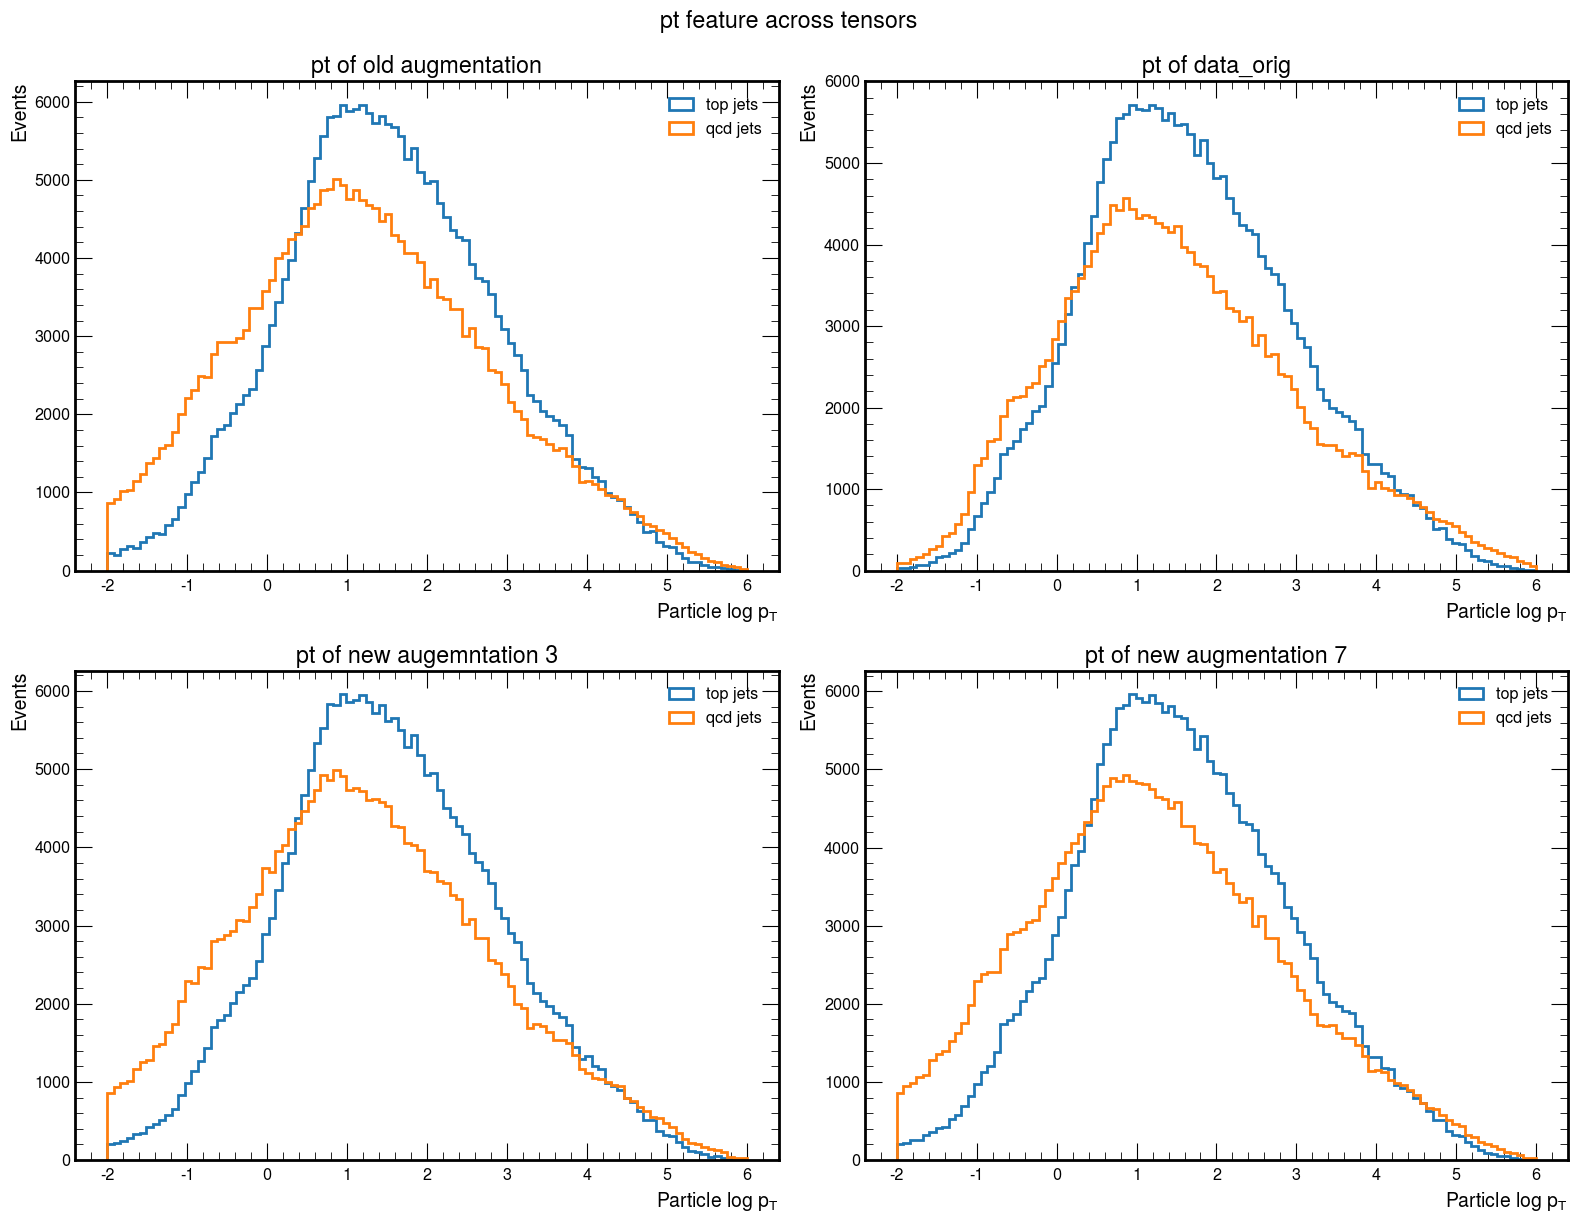

feature eta corresponding to index 0


10000it [00:11, 877.30it/s]
10000it [00:10, 959.28it/s]
10000it [00:12, 831.10it/s]
10000it [00:11, 868.11it/s]


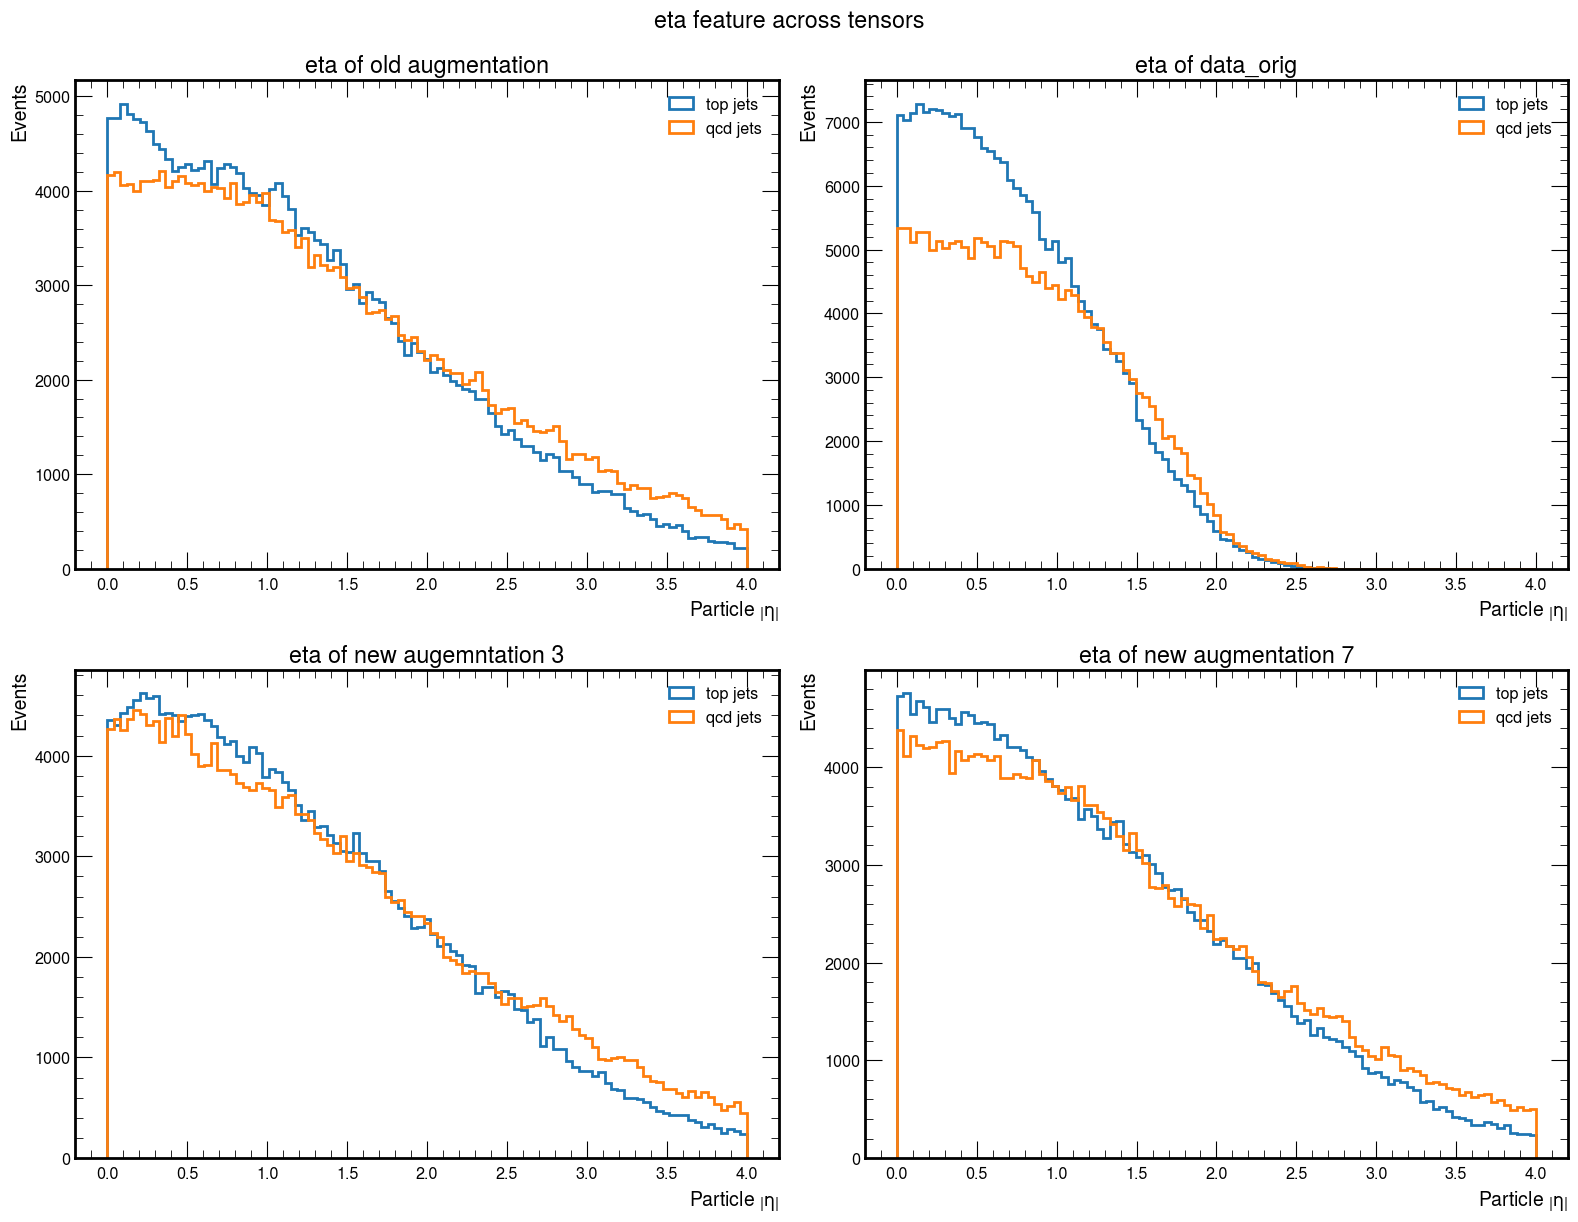

feature phi corresponding to index 1


10000it [00:11, 866.04it/s]
10000it [00:10, 944.23it/s]
10000it [00:11, 900.98it/s]
10000it [00:11, 852.56it/s]


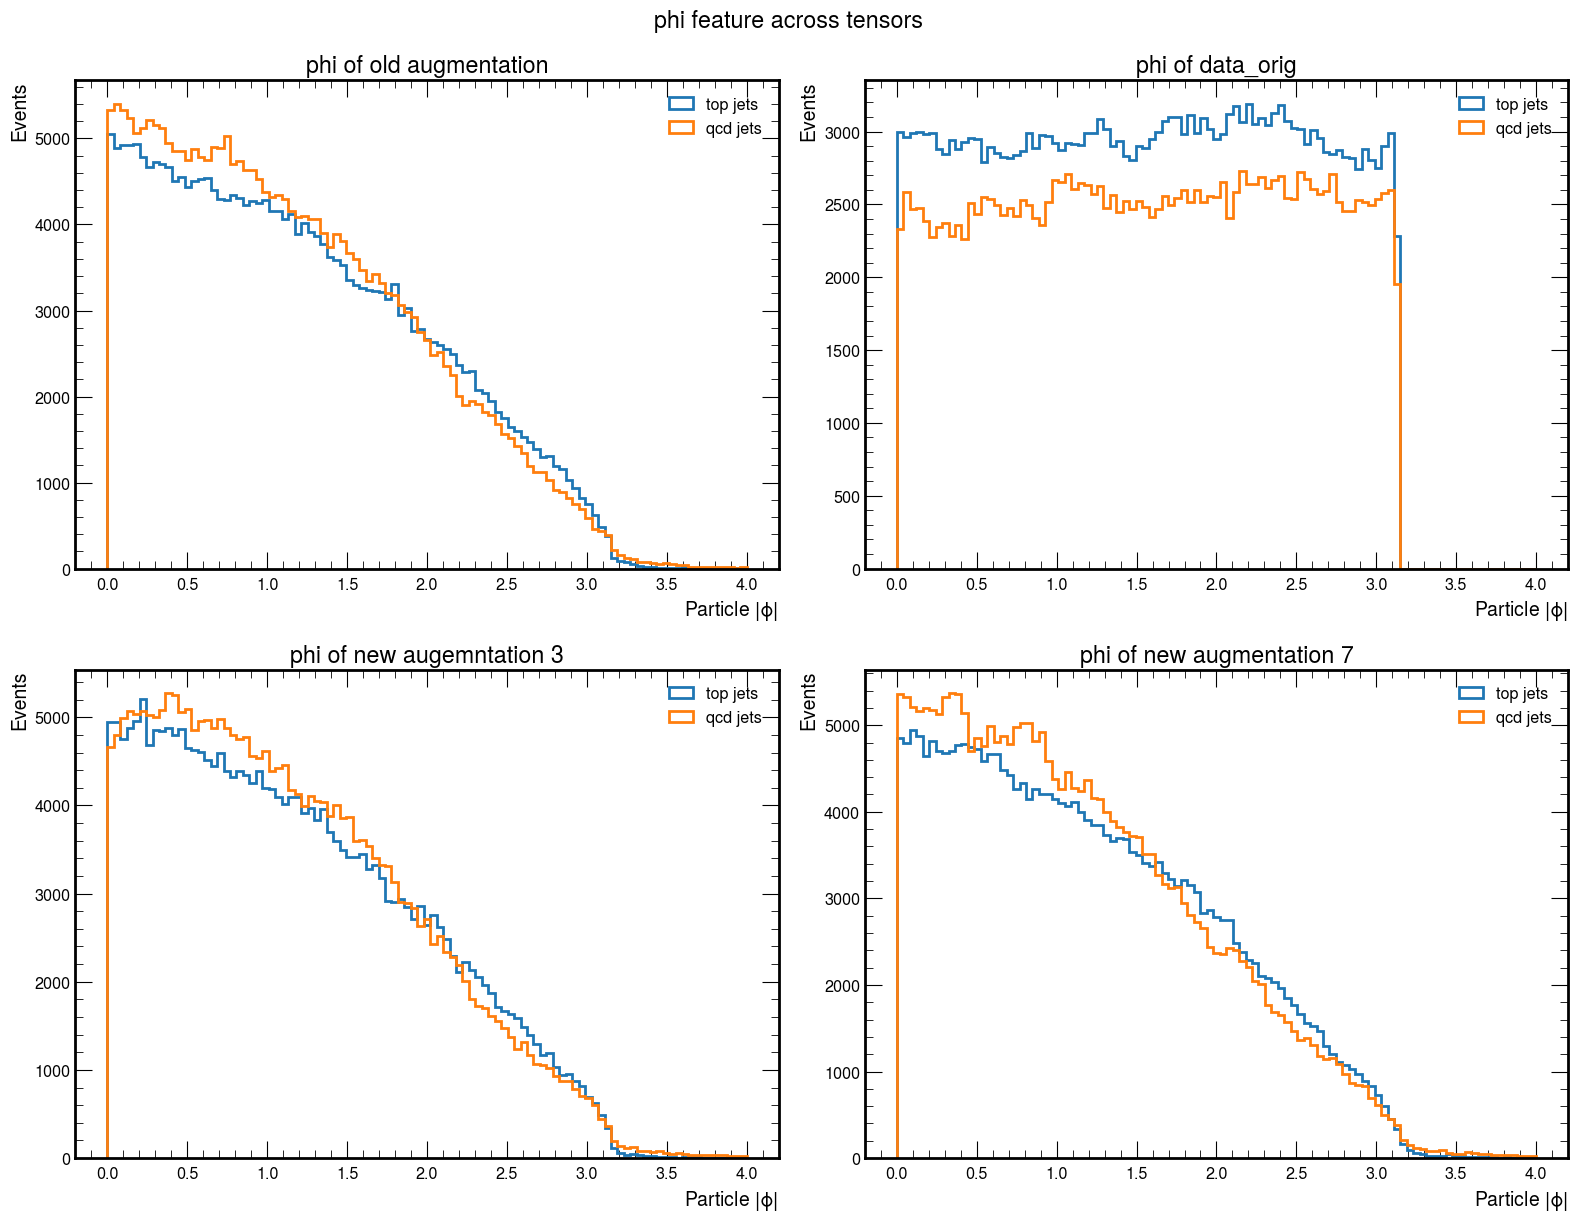

In [45]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

# Features to look at and their corresponding indices
feature_dict = {'pt': 2, 'eta': 0, 'phi': 1}  # Replace with actual indices
features_to_plot = ['pt', 'eta', 'phi']
tensor_names = ['old augmentation', 'data_orig', 'new augemntation 3', 'new augmentation 7']
# tensors = [aug_old_3_i, torch.Tensor(data_7).transpose(1,2), aug_new_3_i, aug_new_7_i]
tensors = [aug_old_3_j[:10000], torch.Tensor(data_7).transpose(1,2)[:10000], aug_new_3_j[:10000], aug_new_7_j[:10000]]
labels = labels_3  # Using the same labels tensor for all four tensors

# Set plot parameters
plt.rcParams.update({'font.size': 14})

# Iterate over each feature to create separate 2x2 plots
for feature in features_to_plot:
    index = feature_dict[feature]
    print(f"feature {feature} corresponding to index {index}")
    
    # Prepare the figure for the current feature
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    axes = axes.flatten()
    
    # Iterate over each tensor and plot
    for i, (tensor, tensor_name) in enumerate(zip(tensors, tensor_names)):
        features = {'top': [], 'qcd': []}
        
        # Collect features based on labels
        for jet, class_label in tqdm(zip(tensor, labels)):
            if class_label == 1:
                label = 'top'
            else:
                label = 'qcd'
            
            for particle in jet:
                if particle[index] != 0:
                    if feature == 'pt':
                        if tensor_name in ['old augmentation', 'new augemntation 3']:
                            features[label].append(np.log(particle[index]))
                        else:
                            features[label].append(particle[index])
                    else:
                        features[label].append(np.abs(particle[index]))
        
        # Plot histograms for the current feature
        ax = axes[i]
        start, end = 0, 4 # plotting range
        if feature == "pt":
            start, end = -2, 6
        ax.hist(features['top'], bins=np.linspace(start, end, 100), histtype='step', linewidth=2, label=f"top jets")
        ax.hist(features['qcd'], bins=np.linspace(start, end, 100), histtype='step', linewidth=2, label=f"qcd jets")
        
        # Set labels and title for the subplot
        ax.legend()
        ax.set_xlabel(feature_label[feature]);
        ax.set_ylabel(r"Events"); 
        ax.set_title(f"{feature} of {tensor_name}")

    # Adjust layout and show/save the plot for the current feature
    plt.tight_layout()
    plt.suptitle(f"{feature} feature across tensors", y=1.02)
    plt.savefig(f"{save_path}/{feature}_feature_comparison_no_rescale_j.png", bbox_inches='tight', dpi=300)
    plt.show()

feature pt corresponding to index 2


100001it [03:08, 530.42it/s]
100001it [01:18, 1276.15it/s]
100001it [03:04, 543.20it/s]
100001it [01:21, 1231.00it/s]


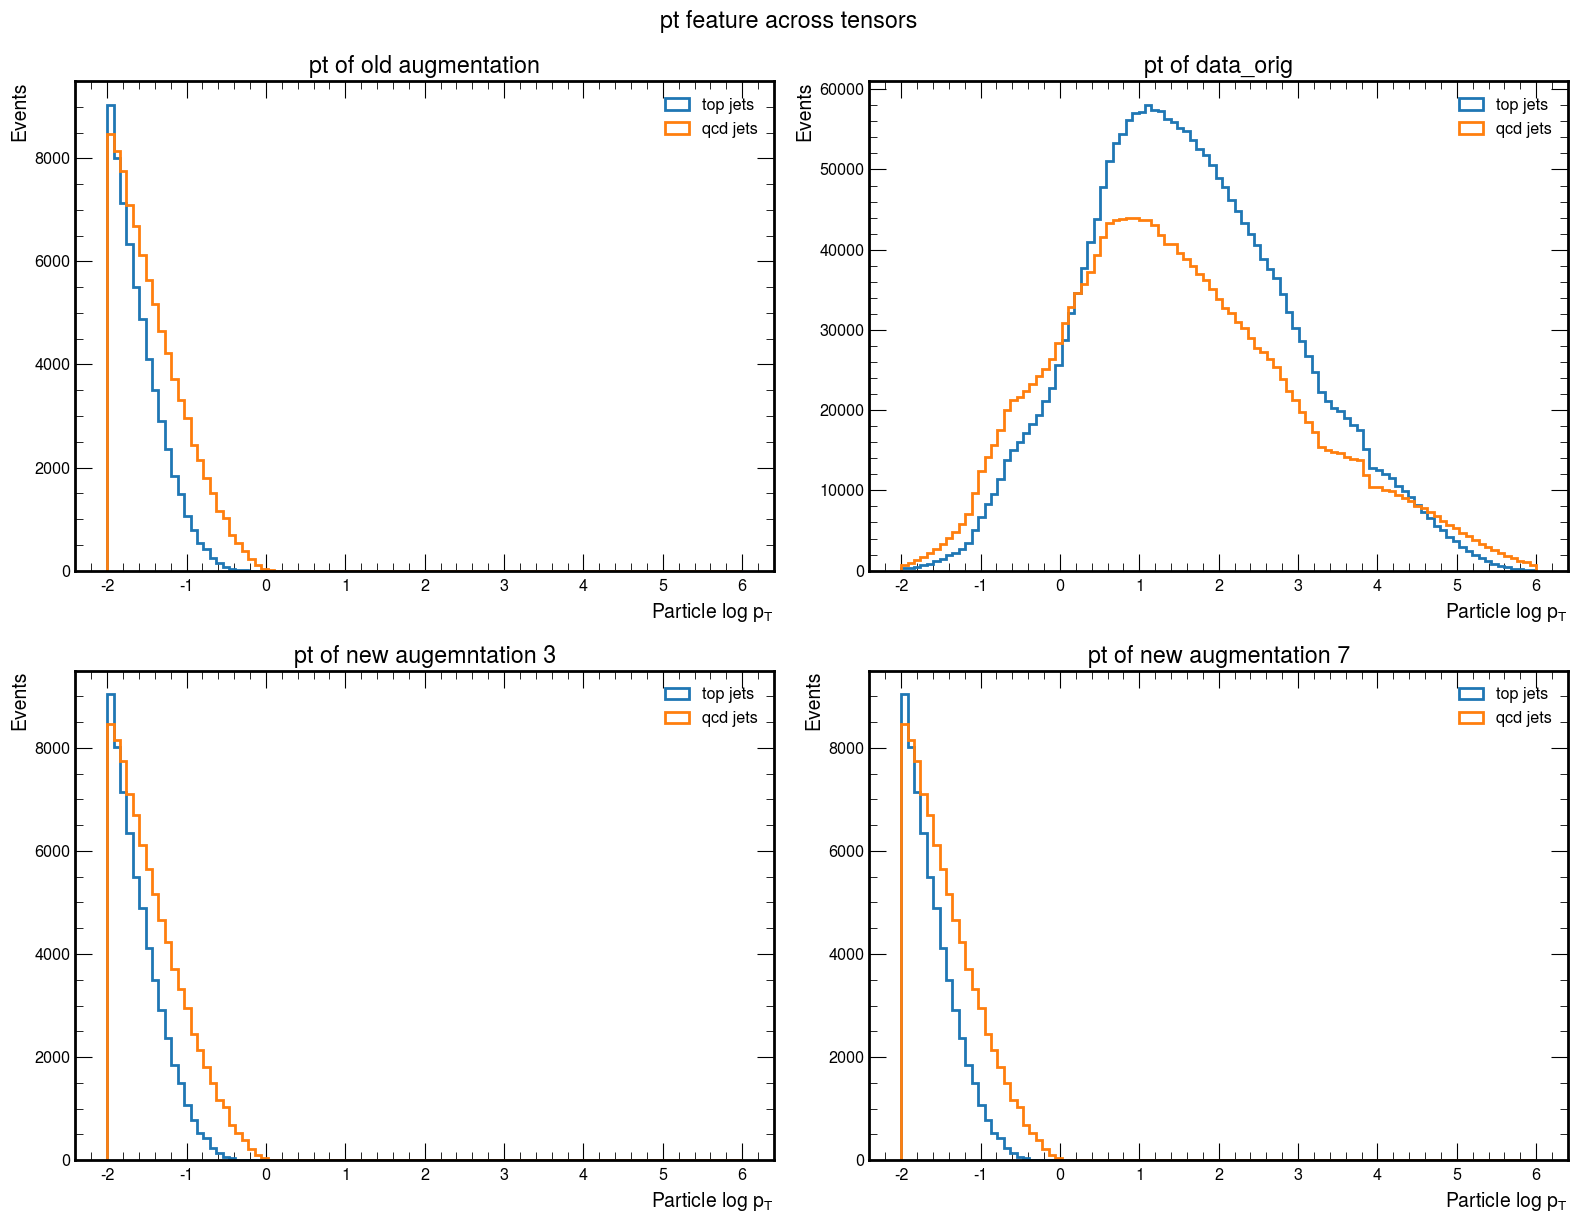

feature eta corresponding to index 0


100001it [03:07, 534.07it/s]
100001it [03:02, 548.70it/s]
100001it [03:02, 548.57it/s]
100001it [03:03, 544.72it/s]


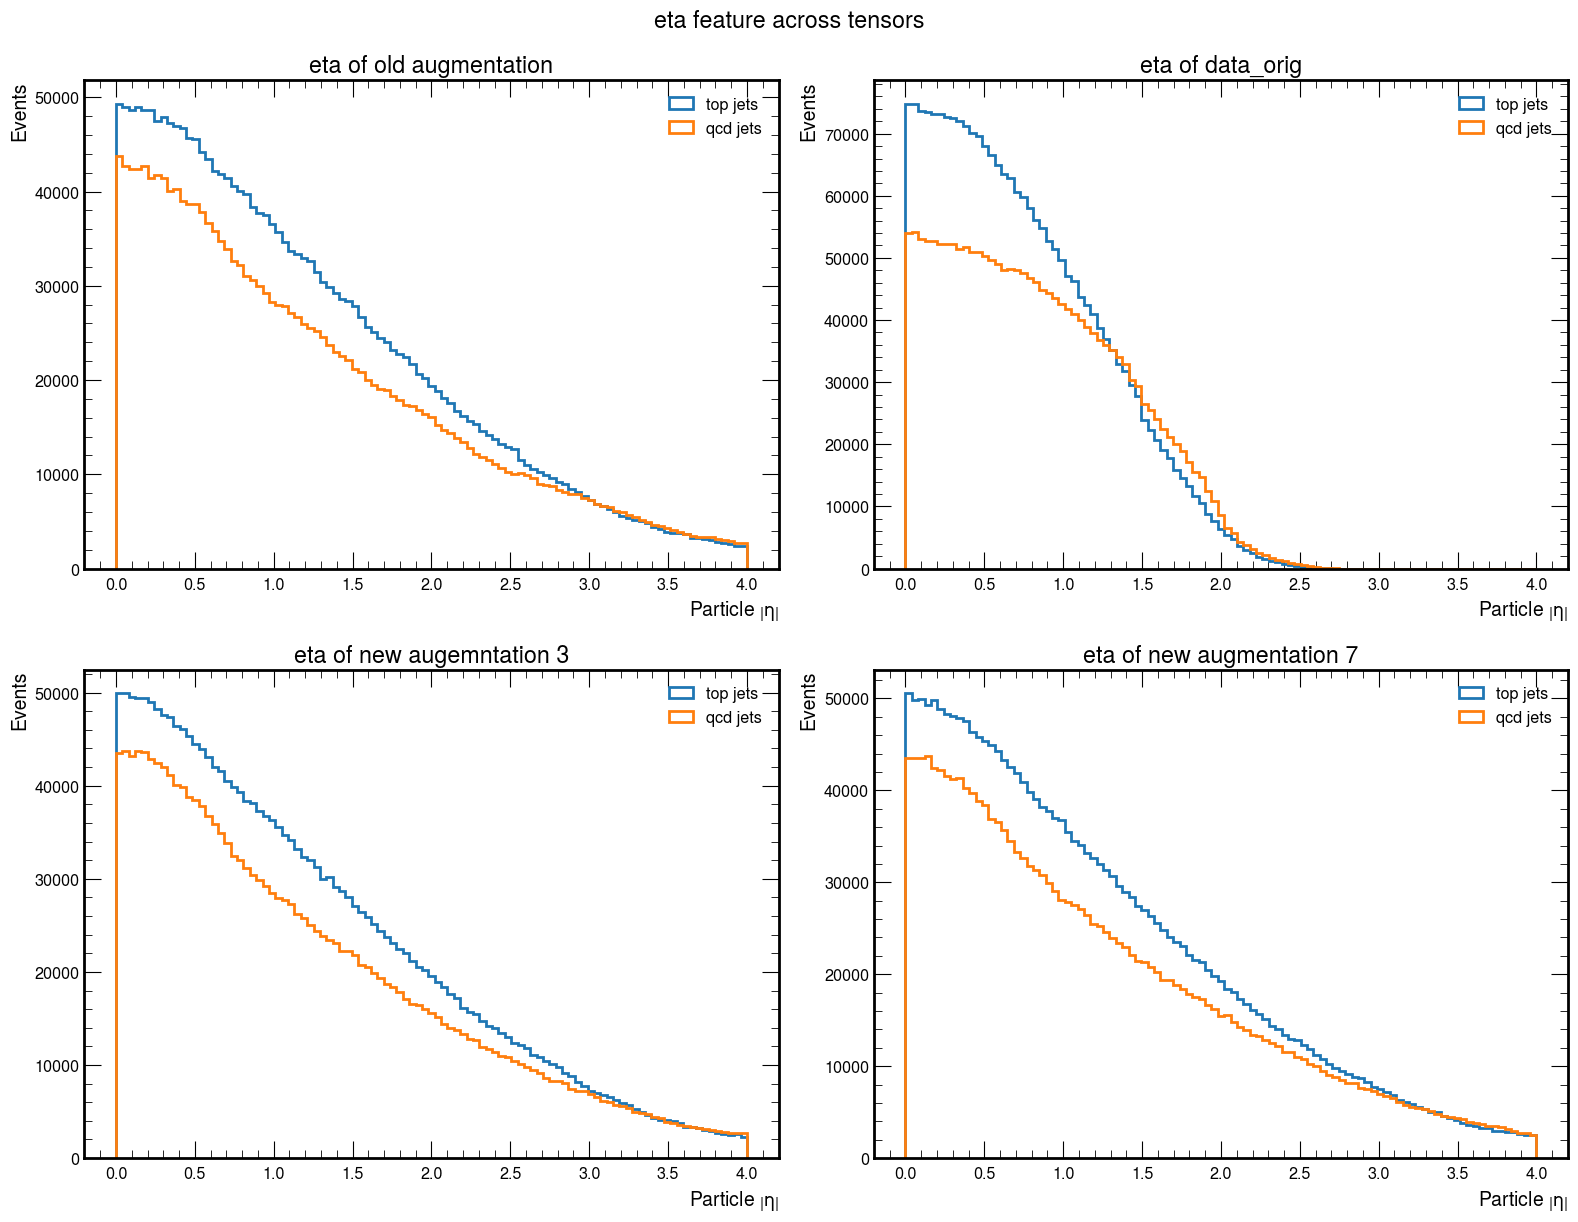

feature phi corresponding to index 1


100001it [03:04, 542.76it/s]
100001it [03:06, 536.09it/s]
100001it [02:59, 557.33it/s]
100001it [03:05, 538.64it/s]


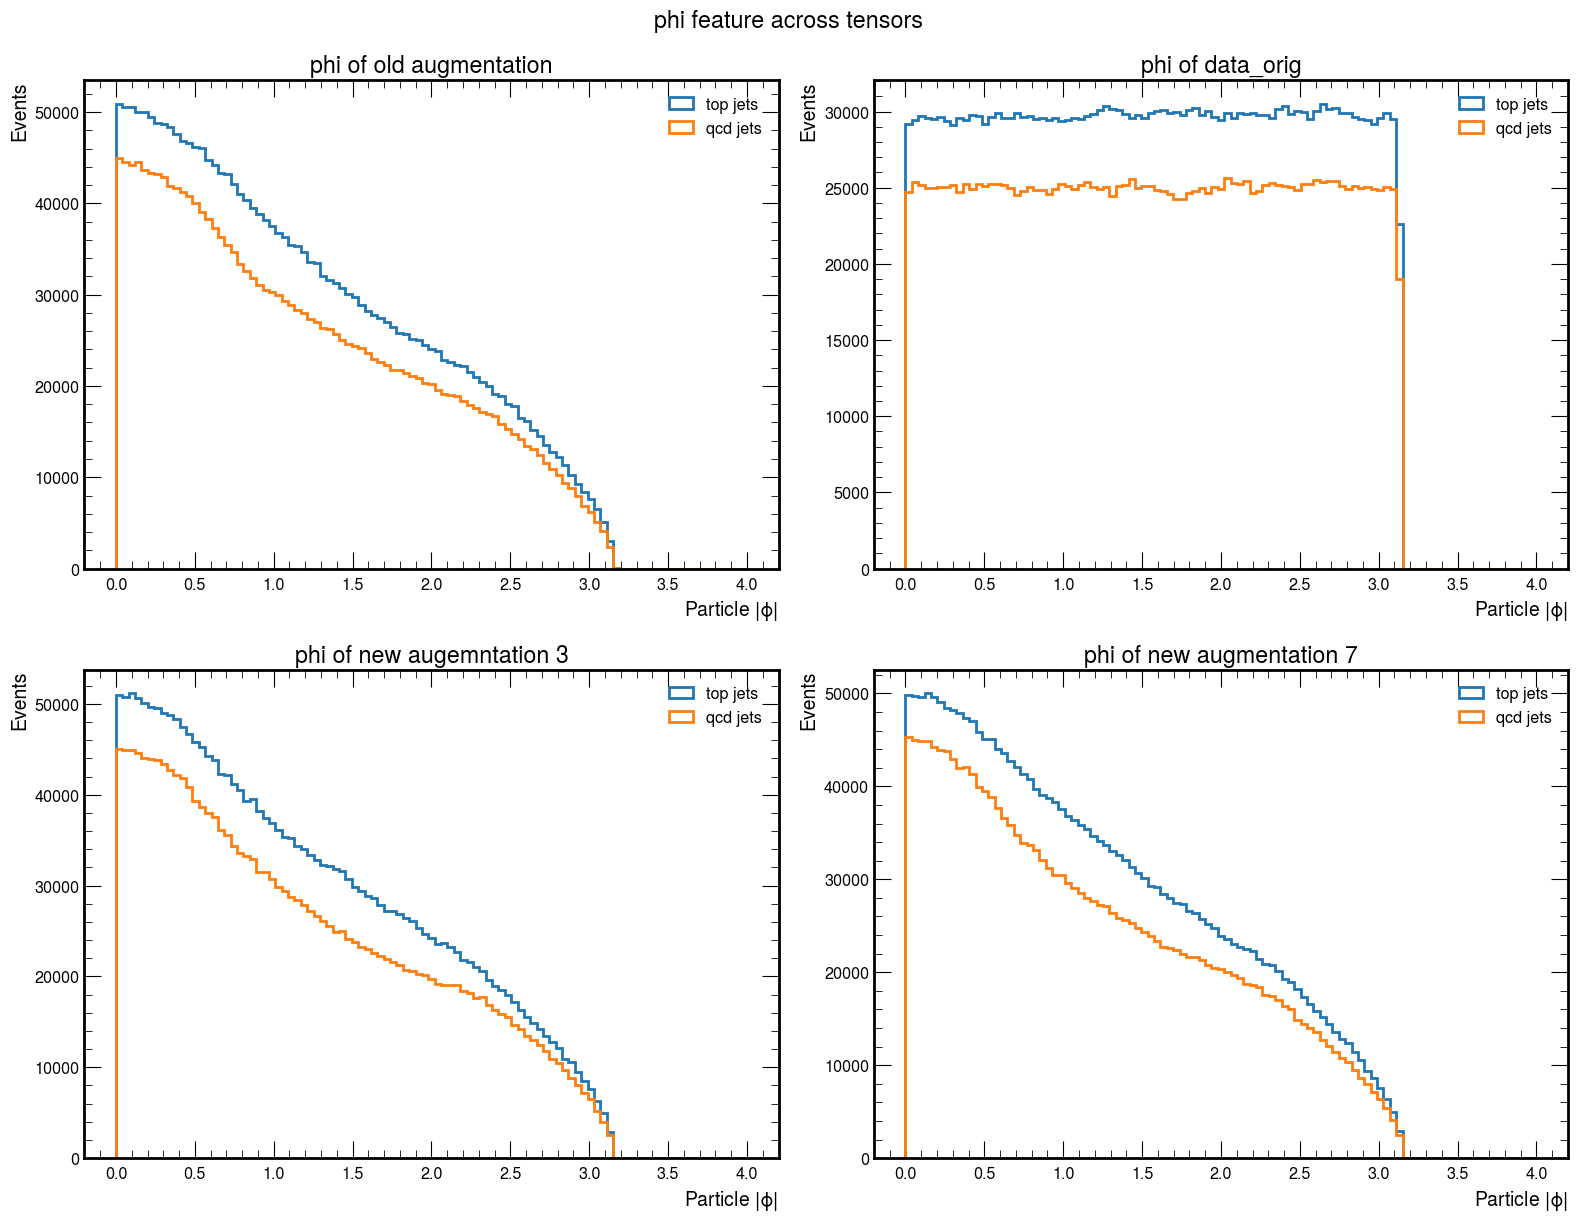

In [46]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

# Features to look at and their corresponding indices
feature_dict = {'pt': 2, 'eta': 0, 'phi': 1}  # Replace with actual indices
features_to_plot = ['pt', 'eta', 'phi']
tensor_names = ['old augmentation', 'data_orig', 'new augemntation 3', 'new augmentation 7']
tensors = [aug_old_3_i, torch.Tensor(data_7).transpose(1,2), aug_new_3_i, aug_new_7_i]
# tensors = [aug_old_3_i[:10000], torch.Tensor(data_7).transpose(1,2)[:10000], aug_new_3_i[:10000], aug_new_7_i[:10000]]
labels = labels_3  # Using the same labels tensor for all four tensors

# Set plot parameters
plt.rcParams.update({'font.size': 14})

# Iterate over each feature to create separate 2x2 plots
for feature in features_to_plot:
    index = feature_dict[feature]
    print(f"feature {feature} corresponding to index {index}")
    
    # Prepare the figure for the current feature
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    axes = axes.flatten()
    
    # Iterate over each tensor and plot
    for i, (tensor, tensor_name) in enumerate(zip(tensors, tensor_names)):
        features = {'top': [], 'qcd': []}
        
        # Collect features based on labels
        for jet, class_label in tqdm(zip(tensor, labels)):
            if class_label == 1:
                label = 'top'
            else:
                label = 'qcd'
            
            for particle in jet:
                if particle[index] != 0:
                    if feature == 'pt':
                        if tensor_name in ['old augmentation', 'new augemntation 3']:
                            features[label].append(np.log(particle[index]))
                        else:
                            features[label].append(particle[index])
                    else:
                        features[label].append(np.abs(particle[index]))
        
        # Plot histograms for the current feature
        ax = axes[i]
        start, end = 0, 4 # plotting range
        if feature == "pt":
            start, end = -2, 6
        ax.hist(features['top'], bins=np.linspace(start, end, 100), histtype='step', linewidth=2, label=f"top jets")
        ax.hist(features['qcd'], bins=np.linspace(start, end, 100), histtype='step', linewidth=2, label=f"qcd jets")
        
        # Set labels and title for the subplot
        ax.legend()
        ax.set_xlabel(feature_label[feature]);
        ax.set_ylabel(r"Events"); 
        ax.set_title(f"{feature} of {tensor_name}")

    # Adjust layout and show/save the plot for the current feature
    plt.tight_layout()
    plt.suptitle(f"{feature} feature across tensors", y=1.02)
    plt.savefig(f"{save_path}/{feature}_feature_comparison_full.png", bbox_inches='tight', dpi=300)
    plt.show()

feature pt corresponding to index 2


100001it [00:05, 17799.54it/s]
100001it [00:03, 29317.65it/s]
100001it [00:05, 17072.39it/s]
100001it [00:12, 8287.53it/s]


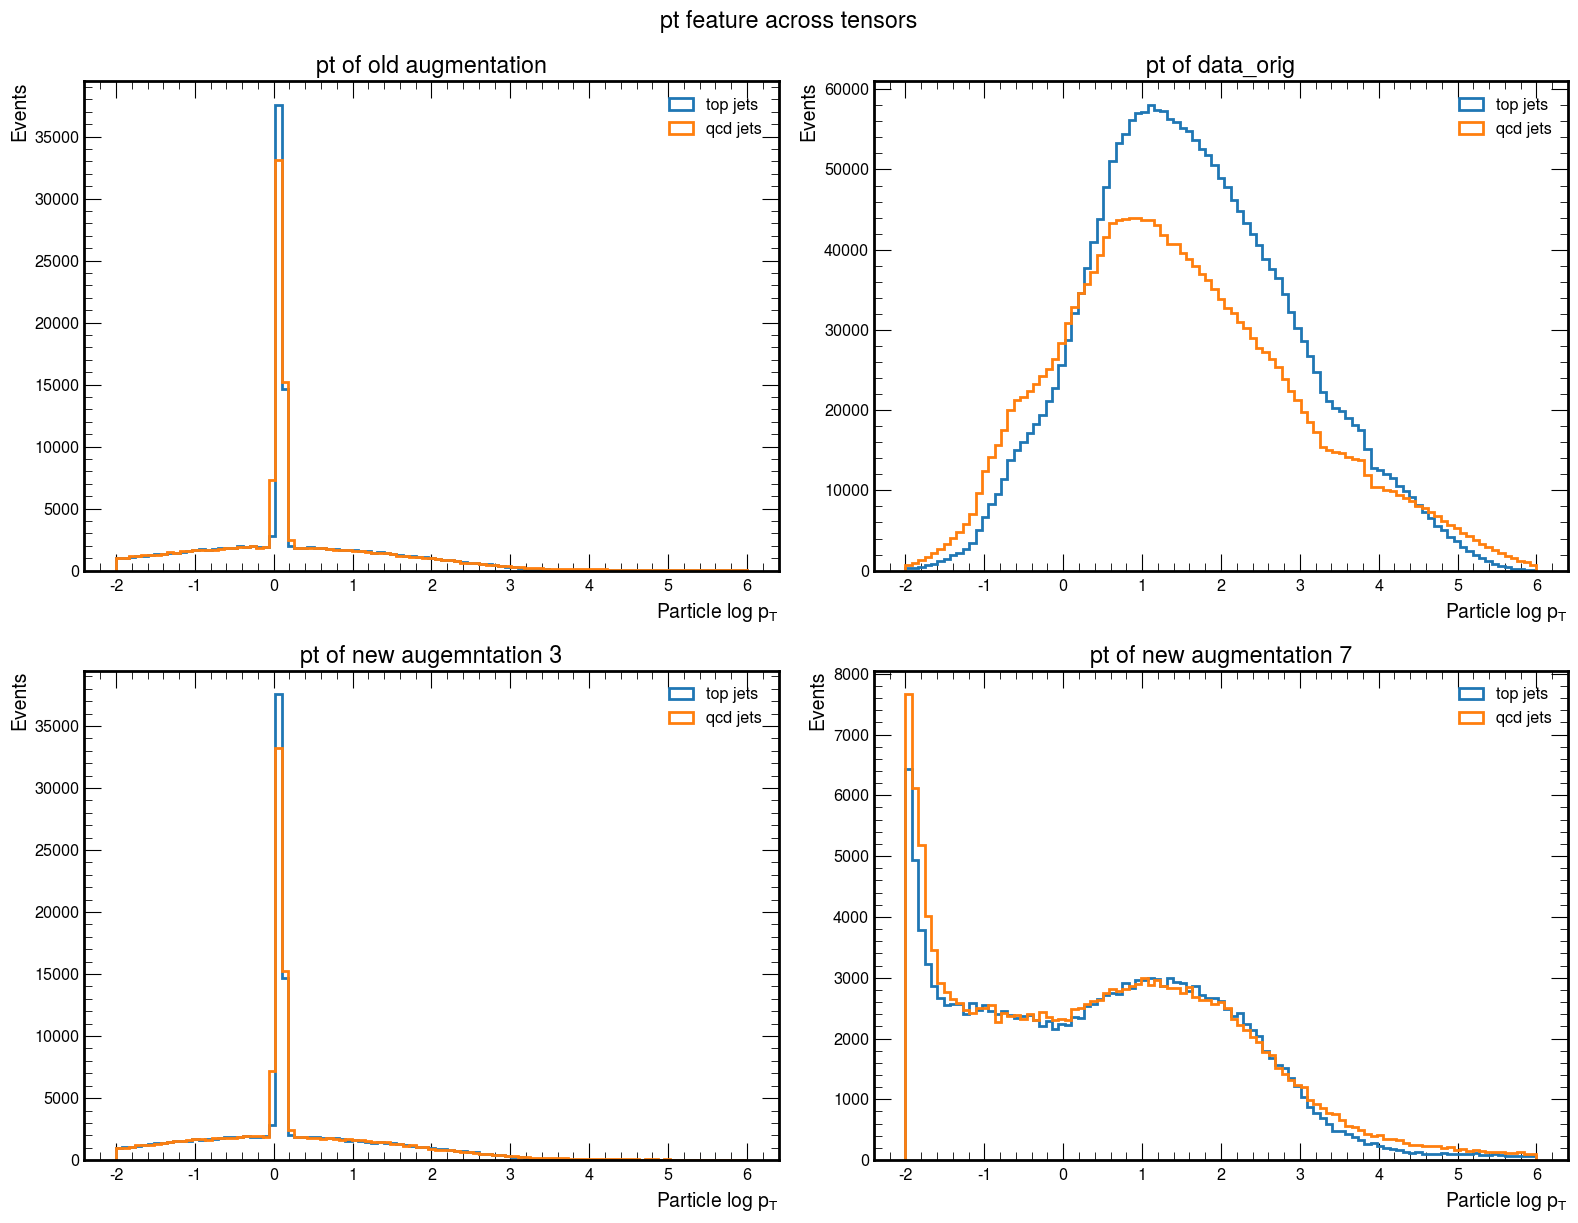

feature eta corresponding to index 0


100001it [00:12, 7779.58it/s]
100001it [00:07, 13475.32it/s]
100001it [00:12, 7817.63it/s]
100001it [00:27, 3573.90it/s]


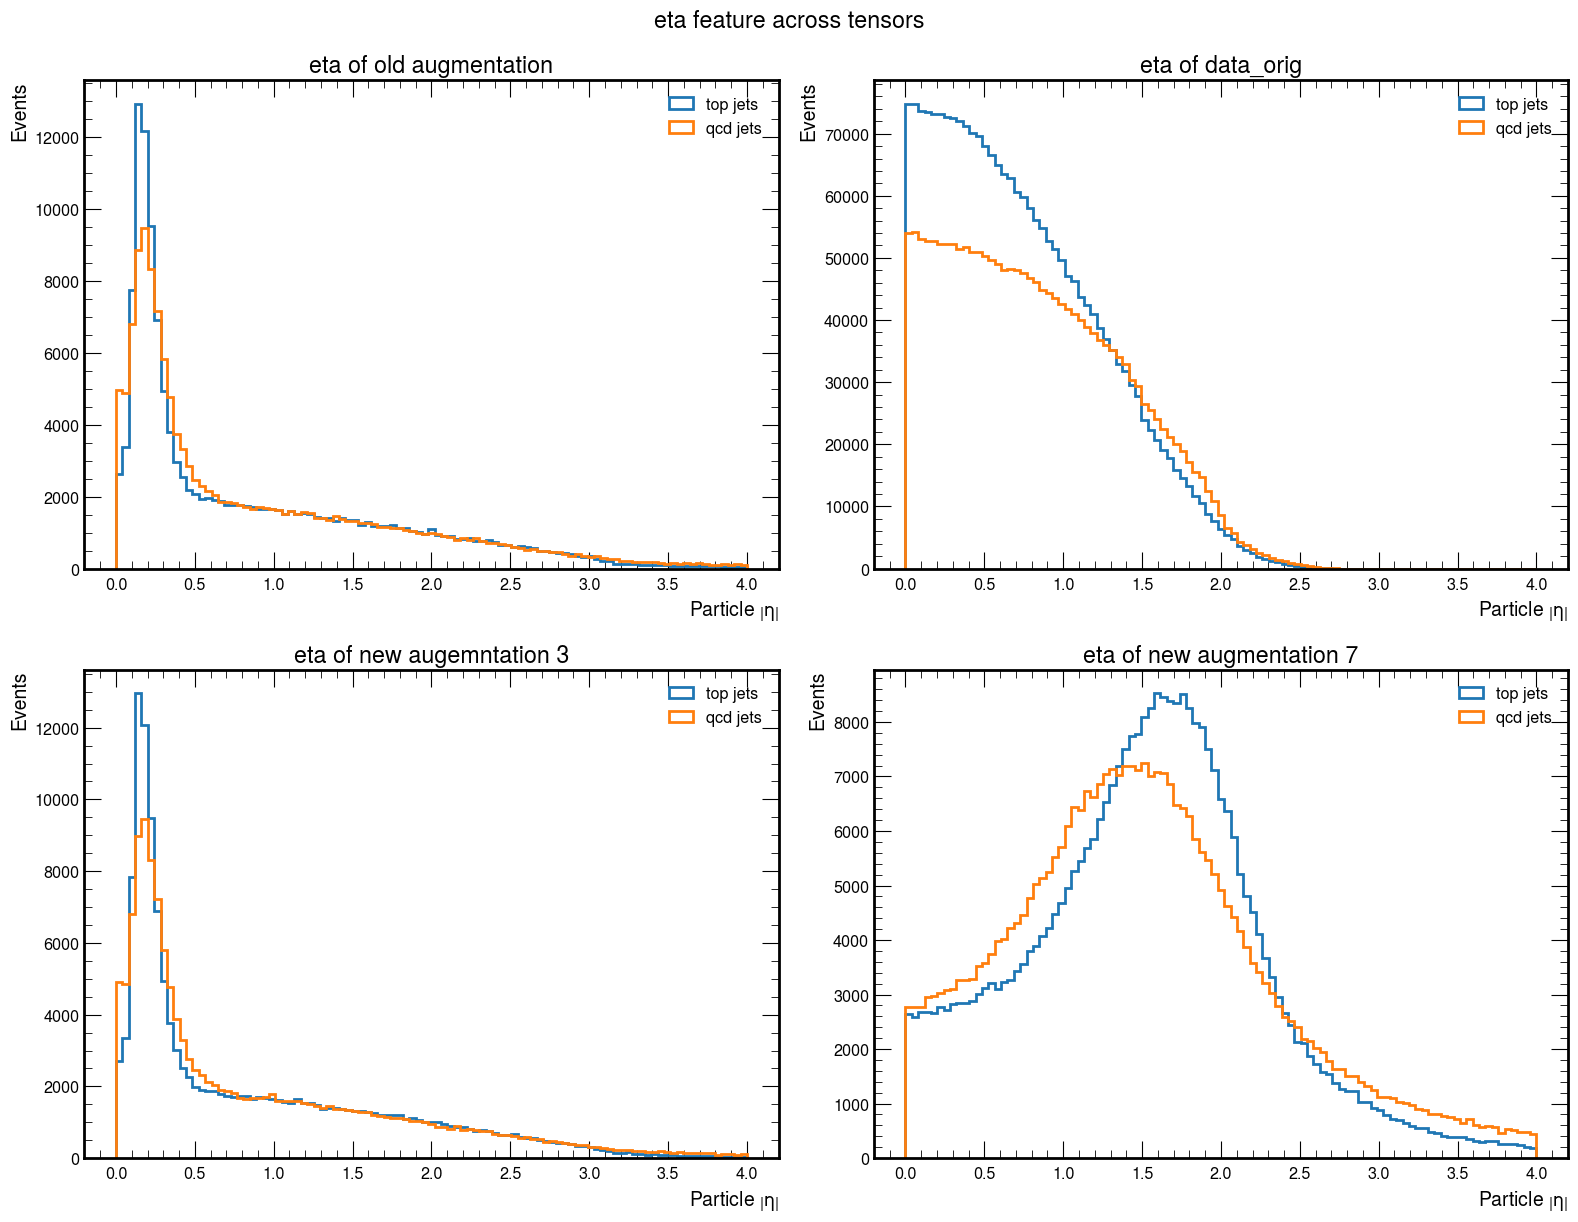

feature phi corresponding to index 1


100001it [00:12, 7939.72it/s]
100001it [00:07, 13632.38it/s]
100001it [00:12, 7884.12it/s]
100001it [00:27, 3622.86it/s]


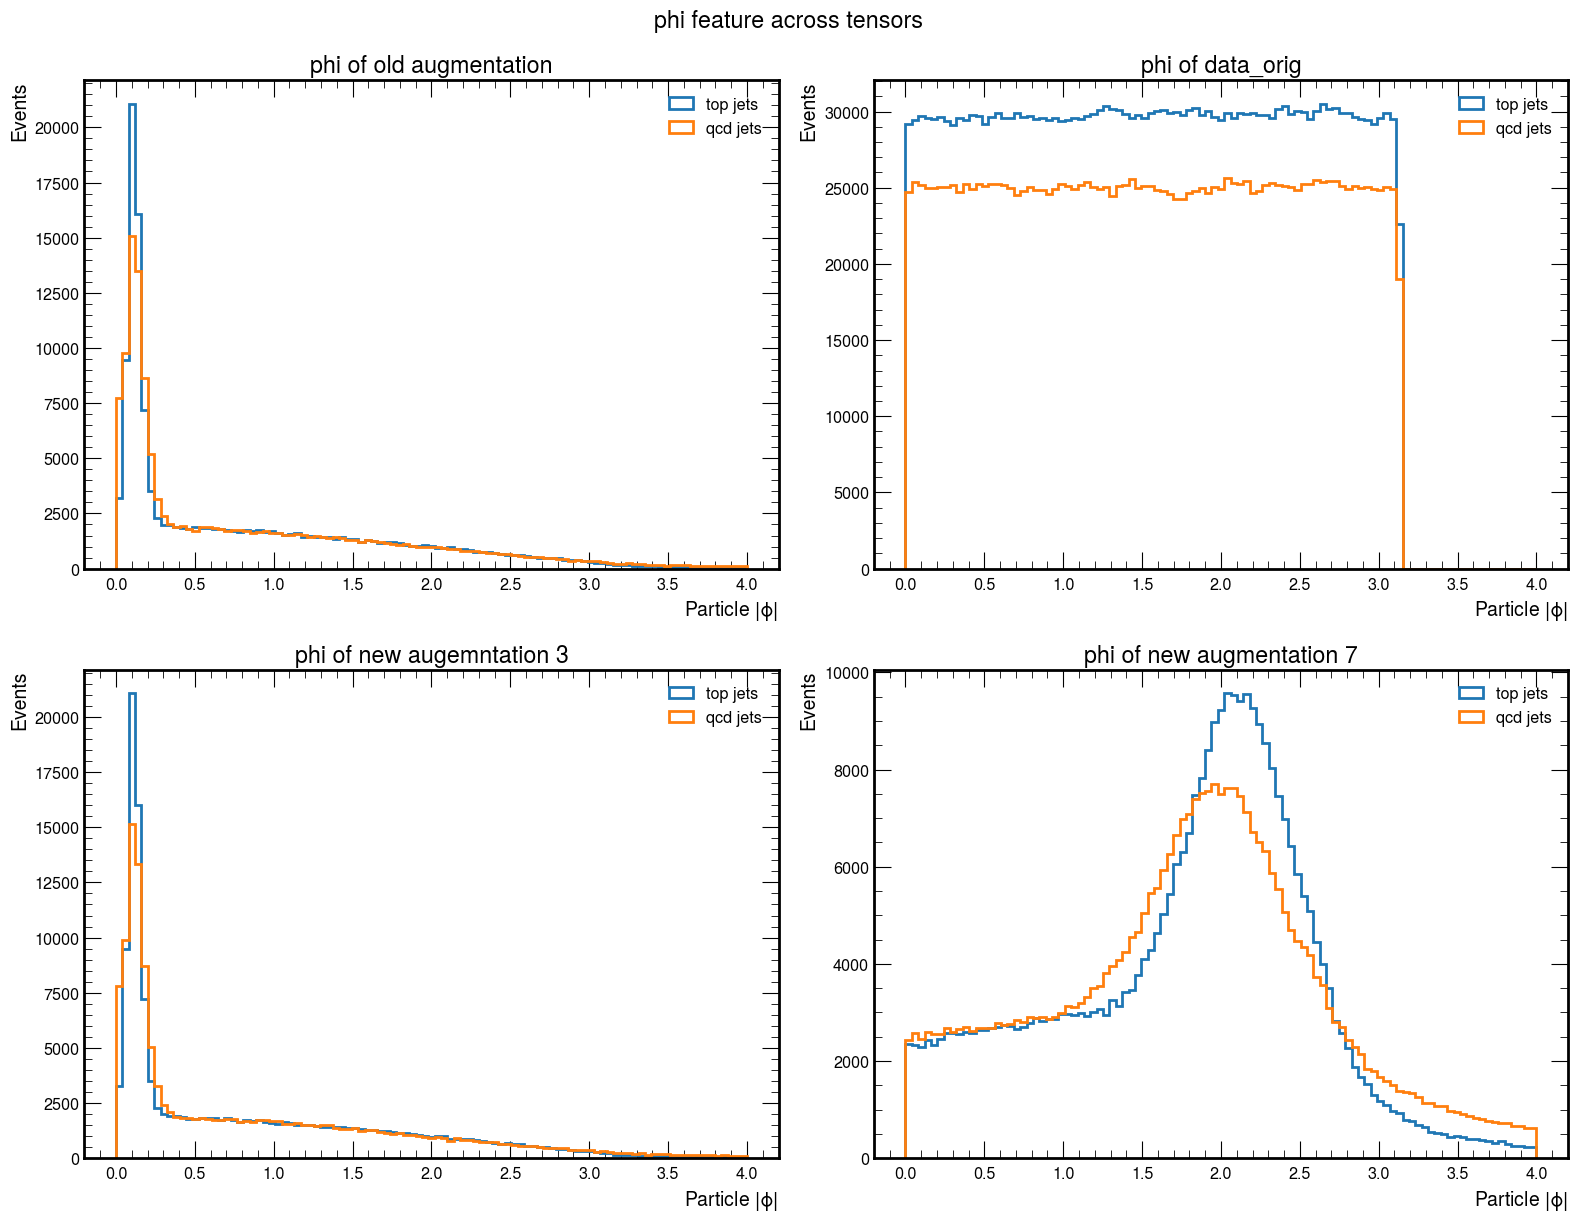

In [29]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

# Features to look at and their corresponding indices
feature_dict = {'pt': 2, 'eta': 0, 'phi': 1}  # Replace with actual indices
features_to_plot = ['pt', 'eta', 'phi']
tensor_names = ['old augmentation', 'data_orig', 'new augemntation 3', 'new augmentation 7']
tensors = [aug_old_3_j, data_7, aug_new_3_j, aug_new_7_j]
labels = labels_3  # Using the same labels tensor for all four tensors

# Set plot parameters
plt.rcParams.update({'font.size': 14})

# Iterate over each feature to create separate 2x2 plots
for feature in features_to_plot:
    index = feature_dict[feature]
    print(f"feature {feature} corresponding to index {index}")
    
    # Prepare the figure for the current feature
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    axes = axes.flatten()
    
    # Iterate over each tensor and plot
    for i, (tensor, tensor_name) in enumerate(zip(tensors, tensor_names)):
        features = {'top': [], 'qcd': []}
        
        # Collect features based on labels
        for jet, class_label in tqdm(zip(tensor, labels)):
            if class_label == 1:
                label = 'top'
            else:
                label = 'qcd'
            
            for particle in jet.T:
                if particle[index] != 0:
                    if feature == 'pt':
                        if feature in ['old augmentation', 'new augemntation 3']:
                            features[label].append(np.log(particle[index]))
                        else:
                            features[label].append(particle[index])
                    else:
                        features[label].append(np.abs(particle[index]))
        
        # Plot histograms for the current feature
        ax = axes[i]
        start, end = 0, 4 # plotting range
        if feature == "pt":
            start, end = -2, 6
        ax.hist(features['top'], bins=np.linspace(start, end, 100), histtype='step', linewidth=2, label=f"top jets")
        ax.hist(features['qcd'], bins=np.linspace(start, end, 100), histtype='step', linewidth=2, label=f"qcd jets")
        
        # Set labels and title for the subplot
        ax.legend()
        ax.set_xlabel(feature_label[feature]);
        ax.set_ylabel(r"Events"); 
        ax.set_title(f"{feature} of {tensor_name}")

    # Adjust layout and show/save the plot for the current feature
    plt.tight_layout()
    plt.suptitle(f"{feature} feature across tensors", y=1.02)
    plt.savefig(f"{save_path}/{feature}_feature_comparison_j.png", bbox_inches='tight', dpi=300)
    plt.show()

## Inspect new augmentation more carefully  
TODO: edit augmentation to print out theta at different points, then pass in a batch of 10 jets to see when theta gets altered.

In [33]:
aug_new_7_3_i, aug_new_7_3_j = augmentation_new(data_7, True, "cpu", return_3=True)

In [34]:
aug_new_7_3_i.shape

torch.Size([100001, 50, 3])

In [35]:
aug_new_3_i.shape

torch.Size([100001, 50, 3])

feature pt corresponding to index 2


100001it [00:05, 17725.36it/s]
100001it [00:03, 29299.50it/s]
100001it [00:06, 16578.24it/s]
100001it [00:06, 16561.32it/s]


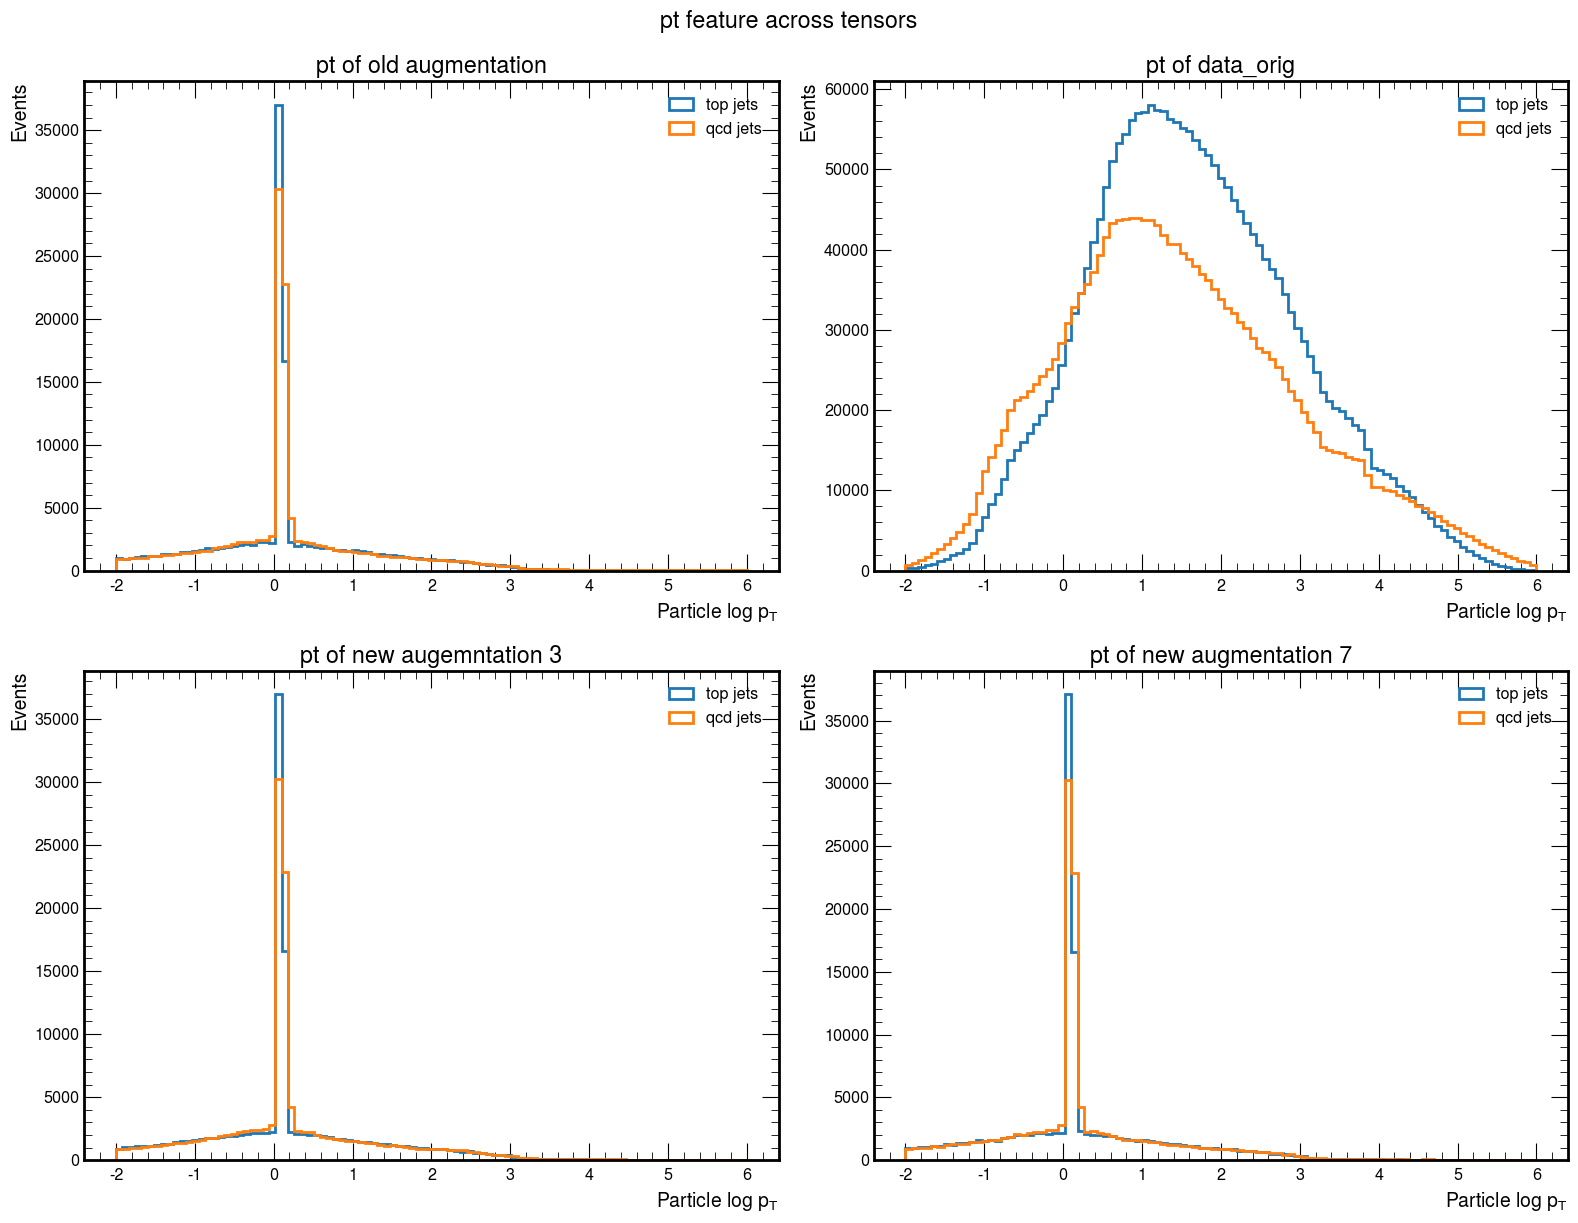

feature eta corresponding to index 0


100001it [00:13, 7683.08it/s]
100001it [00:07, 13684.17it/s]
100001it [00:12, 7842.60it/s]
100001it [00:13, 7581.92it/s]


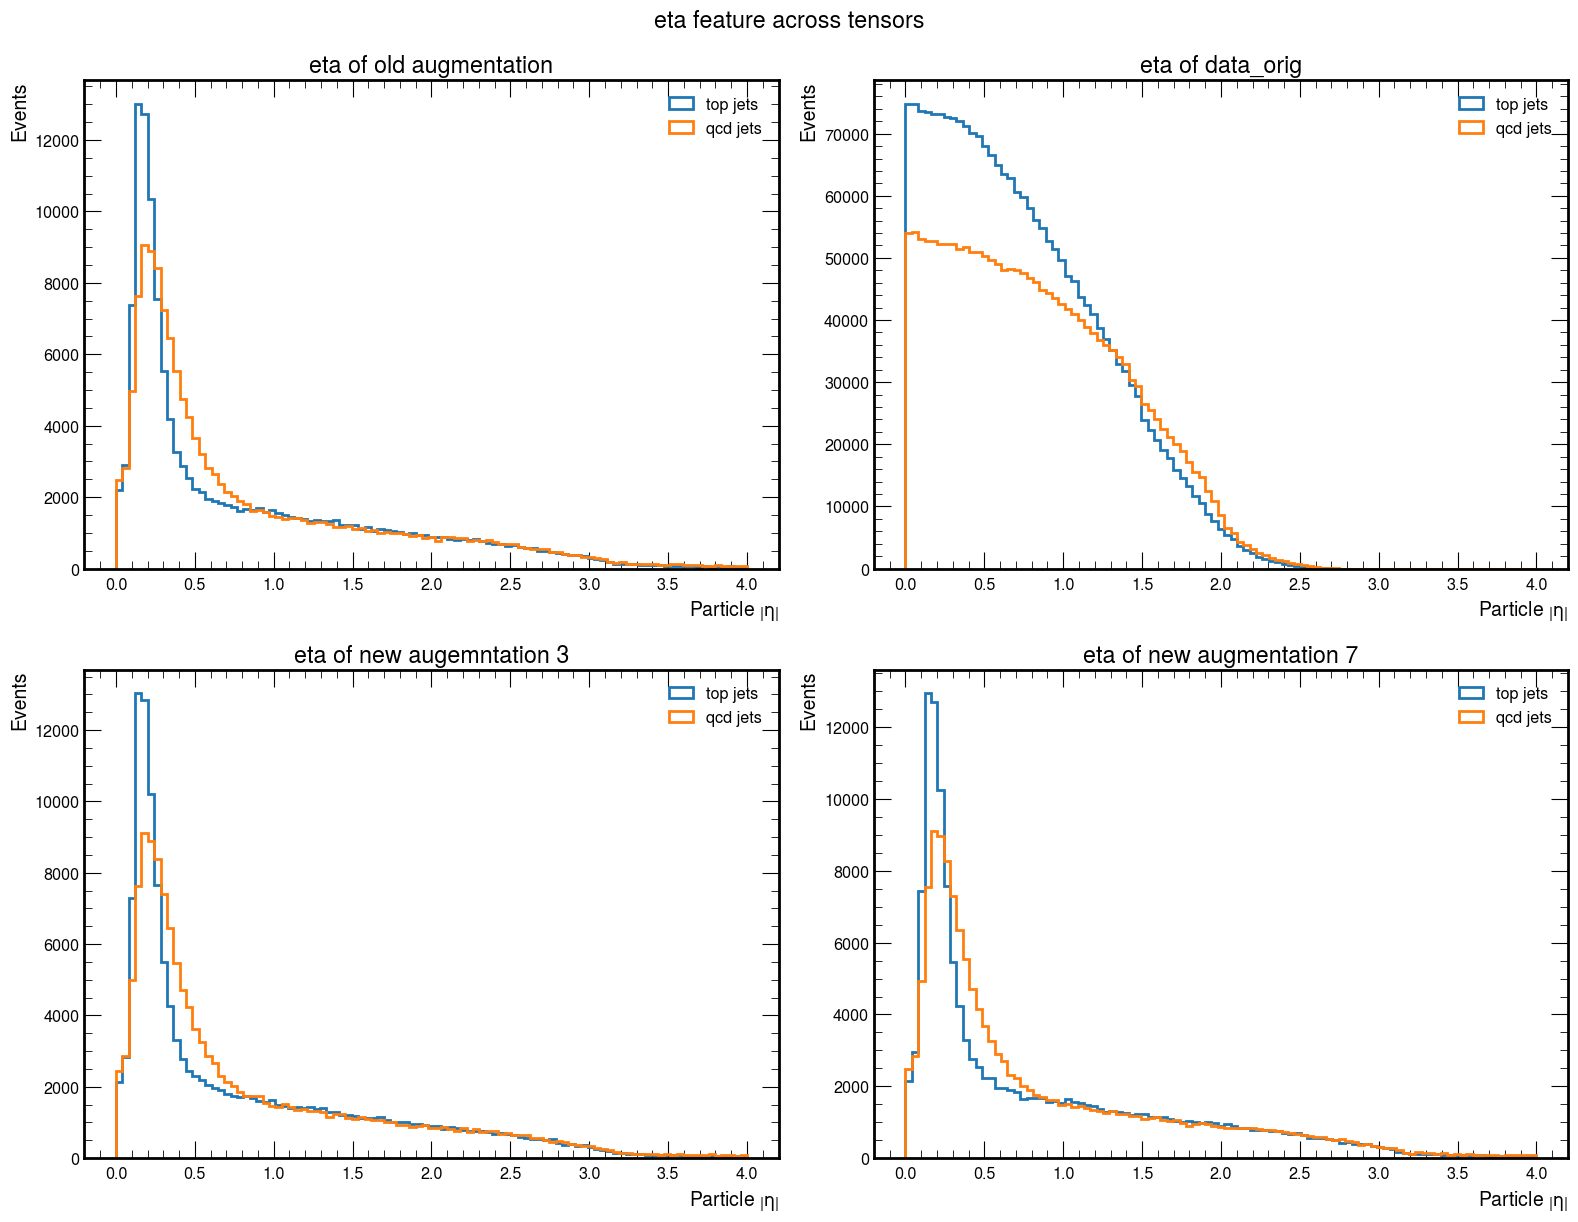

feature phi corresponding to index 1


100001it [00:12, 7729.91it/s]
100001it [00:07, 13506.88it/s]
100001it [00:13, 7526.47it/s]
100001it [00:13, 7426.77it/s]


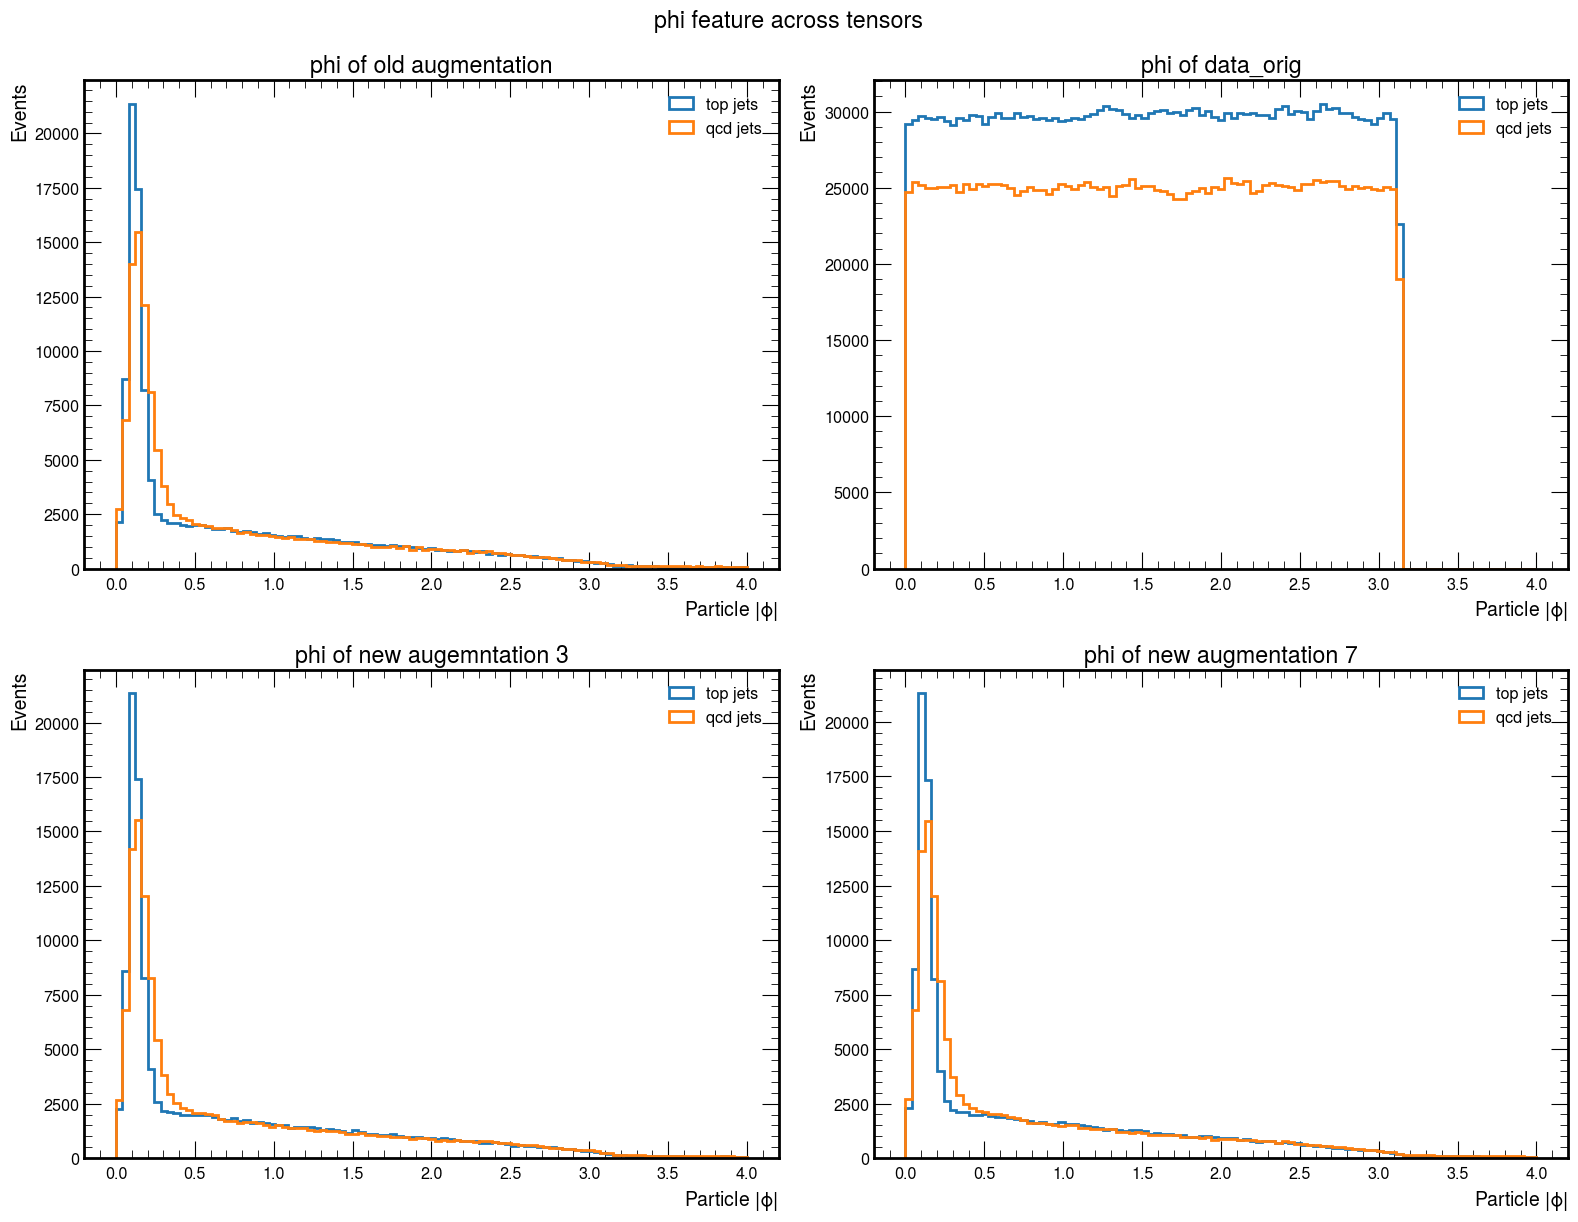

In [36]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

# Features to look at and their corresponding indices
feature_dict = {'pt': 2, 'eta': 0, 'phi': 1}  # Replace with actual indices
features_to_plot = ['pt', 'eta', 'phi']
tensor_names = ['old augmentation', 'data_orig', 'new augemntation 3', 'new augmentation 7']
tensors = [aug_old_3_i, data_7, aug_new_3_i, aug_new_7_3_i]
labels = labels_3  # Using the same labels tensor for all four tensors

# Set plot parameters
plt.rcParams.update({'font.size': 14})

# Iterate over each feature to create separate 2x2 plots
for feature in features_to_plot:
    index = feature_dict[feature]
    print(f"feature {feature} corresponding to index {index}")
    
    # Prepare the figure for the current feature
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    axes = axes.flatten()
    
    # Iterate over each tensor and plot
    for i, (tensor, tensor_name) in enumerate(zip(tensors, tensor_names)):
        features = {'top': [], 'qcd': []}
        
        # Collect features based on labels
        for jet, class_label in tqdm(zip(tensor, labels)):
            if class_label == 1:
                label = 'top'
            else:
                label = 'qcd'
            
            for particle in jet.T:
                if particle[index] != 0:
                    if feature == 'pt':
                        if feature in ['old augmentation', 'new augemntation 3']:
                            features[label].append(np.log(particle[index]))
                        else:
                            features[label].append(particle[index])
                    else:
                        features[label].append(np.abs(particle[index]))
        
        # Plot histograms for the current feature
        ax = axes[i]
        start, end = 0, 4 # plotting range
        if feature == "pt":
            start, end = -2, 6
        ax.hist(features['top'], bins=np.linspace(start, end, 100), histtype='step', linewidth=2, label=f"top jets")
        ax.hist(features['qcd'], bins=np.linspace(start, end, 100), histtype='step', linewidth=2, label=f"qcd jets")
        
        # Set labels and title for the subplot
        ax.legend()
        ax.set_xlabel(feature_label[feature]);
        ax.set_ylabel(r"Events"); 
        ax.set_title(f"{feature} of {tensor_name}")

    # Adjust layout and show/save the plot for the current feature
    plt.tight_layout()
    plt.suptitle(f"{feature} feature across tensors", y=1.02)
#     plt.savefig(f"{save_path}/{feature}_feature_comparison_j.png", bbox_inches='tight', dpi=300)
    plt.show()

In [39]:
aug_new_7_3_i[10, :, 2]

tensor([4.3805e-01, 2.0465e-01, 5.6046e-02, 4.8513e-02, 4.8004e-02, 4.6352e-02,
        2.9959e-02, 2.4953e-02, 2.4265e-02, 1.4447e-02, 1.4031e-02, 1.0883e-02,
        1.0299e-02, 9.8399e-03, 9.7792e-03, 8.6386e-03, 8.6353e-03, 6.5959e-03,
        6.3109e-03, 4.8632e-03, 4.3946e-03, 4.3361e-03, 3.9800e-03, 3.2070e-03,
        2.6803e-03, 2.2137e-03, 2.1466e-03, 1.9115e-03, 1.4851e-03, 1.3932e-03,
        9.5341e-04, 8.4783e-04, 6.9379e-04, 3.4314e-04, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00])

In [40]:
aug_old_3_i[10, :, 2]

tensor([4.3805e-01, 2.0465e-01, 5.6046e-02, 4.8513e-02, 4.8004e-02, 4.6352e-02,
        2.9959e-02, 2.4953e-02, 2.4265e-02, 1.4447e-02, 1.4031e-02, 1.0883e-02,
        1.0299e-02, 9.8399e-03, 9.7792e-03, 8.6386e-03, 8.6353e-03, 6.5959e-03,
        6.3109e-03, 4.8632e-03, 4.3946e-03, 4.3361e-03, 3.9800e-03, 3.2070e-03,
        2.6803e-03, 2.2137e-03, 2.1466e-03, 1.9115e-03, 1.4851e-03, 1.3932e-03,
        9.5341e-04, 8.4783e-04, 6.9379e-04, 3.4314e-04, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00])

In [46]:
(aug_new_7_3_i[:, :, 2] - aug_old_3_i[:, :, 2] <= 1e-3).all()

tensor(True)

## Eta

In [ ]:
save_path = "../plots/examine-augmentations/eta"
os.system(f"mkdir -p {save_path}")  # -p: create parent dirs if needed, exist_ok

feature eta corresponding to index 0


0it [00:00, ?it/s]

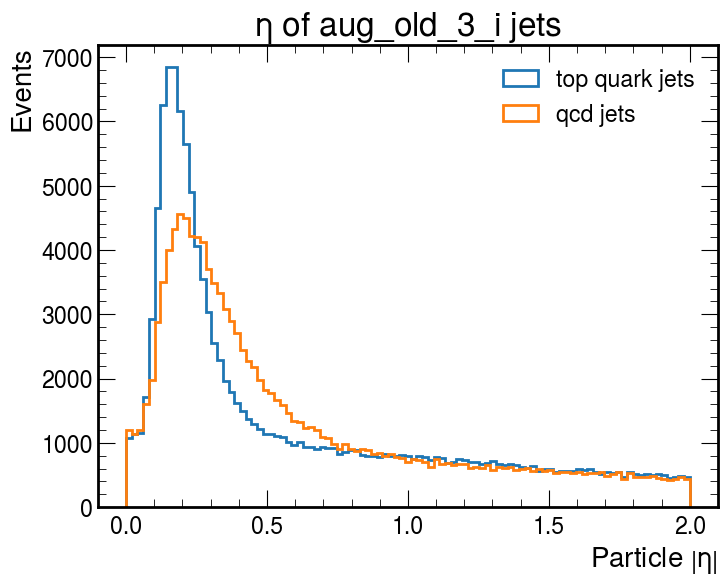

In [34]:
# which feature to look at?
feature = "eta"

index = feature_dict[feature]
print(f"feature {feature} corresponding to index {index}")

features = {}
features["top"] = []
features["qcd"] = []
for jet, class_label in tqdm(zip(aug_old_3_i, labels_3)):
    if class_label==1:
        label = "top"
    else:
        label = "qcd"
    
    for particle in jet.T:
        features[label].append(np.abs(particle[index]))
            
plt.rcParams.update({"font.size": 20})

fig, ax = plt.subplots(figsize=(8, 6))
plt.hist(features["top"], bins=np.linspace(0,2,100), histtype="step", linewidth=2, label=f"top quark jets")
plt.hist(features["qcd"], bins=np.linspace(0,2,100), histtype="step", linewidth=2, label=f"qcd jets")

ax.legend()
ax.set_xlabel(feature_label[feature]);
ax.set_ylabel(r"Events"); 
plt.title("$\eta$ of aug_old_3_i jets")
plt.savefig(f"{save_path}/eta_aug_old_3_i", bbox_inches='tight', dpi=300)
plt.show()          

feature eta corresponding to index 0


100001it [00:04, 23006.73it/s]


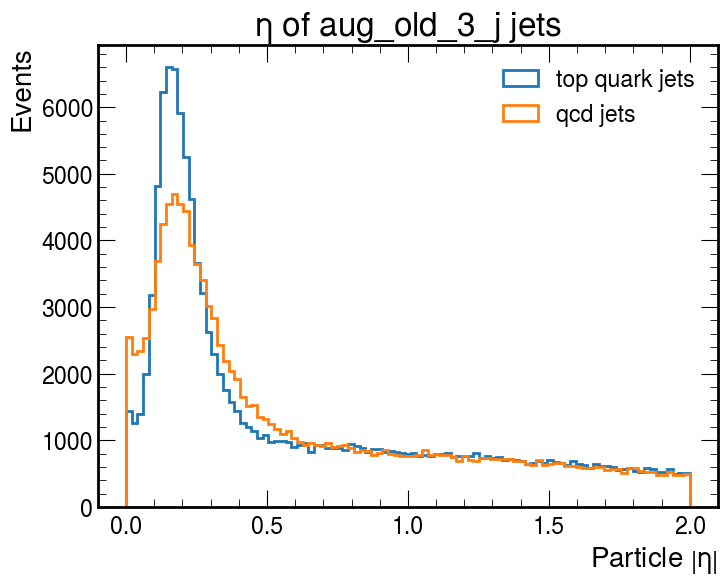

In [36]:
# which feature to look at?
feature = "eta"

index = feature_dict[feature]
print(f"feature {feature} corresponding to index {index}")

features = {}
features["top"] = []
features["qcd"] = []
for jet, class_label in tqdm(zip(aug_old_3_j, labels_3)):
    if class_label==1:
        label = "top"
    else:
        label = "qcd"
    
    for particle in jet.T:
        features[label].append(np.abs(particle[index]))
            
plt.rcParams.update({"font.size": 20})

fig, ax = plt.subplots(figsize=(8, 6))
plt.hist(features["top"], bins=np.linspace(0,2,100), histtype="step", linewidth=2, label=f"top quark jets")
plt.hist(features["qcd"], bins=np.linspace(0,2,100), histtype="step", linewidth=2, label=f"qcd jets")

ax.legend()
ax.set_xlabel(feature_label[feature]);
ax.set_ylabel(r"Events"); 
plt.title("$\eta$ of aug_old_3_j jets")
plt.savefig(f"{save_path}/eta_aug_old_3_j", bbox_inches='tight', dpi=300)
plt.show()          

feature eta corresponding to index 0


100001it [00:04, 22774.76it/s]


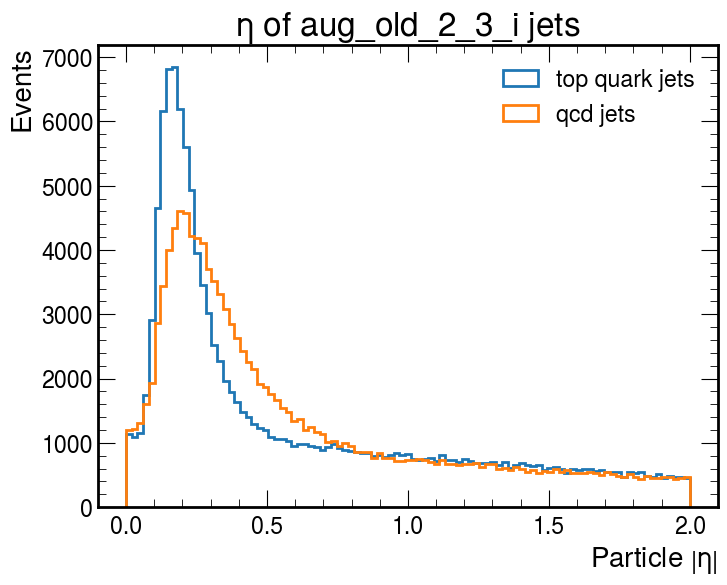

In [37]:
# which feature to look at?
feature = "eta"

index = feature_dict[feature]
print(f"feature {feature} corresponding to index {index}")

features = {}
features["top"] = []
features["qcd"] = []
for jet, class_label in tqdm(zip(aug_old_2_3_i, labels_3)):
    if class_label==1:
        label = "top"
    else:
        label = "qcd"
    
    for particle in jet.T:
        features[label].append(np.abs(particle[index]))
            
plt.rcParams.update({"font.size": 20})

fig, ax = plt.subplots(figsize=(8, 6))
plt.hist(features["top"], bins=np.linspace(0,2,100), histtype="step", linewidth=2, label=f"top quark jets")
plt.hist(features["qcd"], bins=np.linspace(0,2,100), histtype="step", linewidth=2, label=f"qcd jets")

ax.legend()
ax.set_xlabel(feature_label[feature]);
ax.set_ylabel(r"Events"); 
plt.title("$\eta$ of aug_old_2_3_i jets")
plt.savefig(f"{save_path}/eta_aug_old_2_3_i", bbox_inches='tight', dpi=300)
plt.show()          

feature eta corresponding to index 0


100001it [00:04, 24148.26it/s]


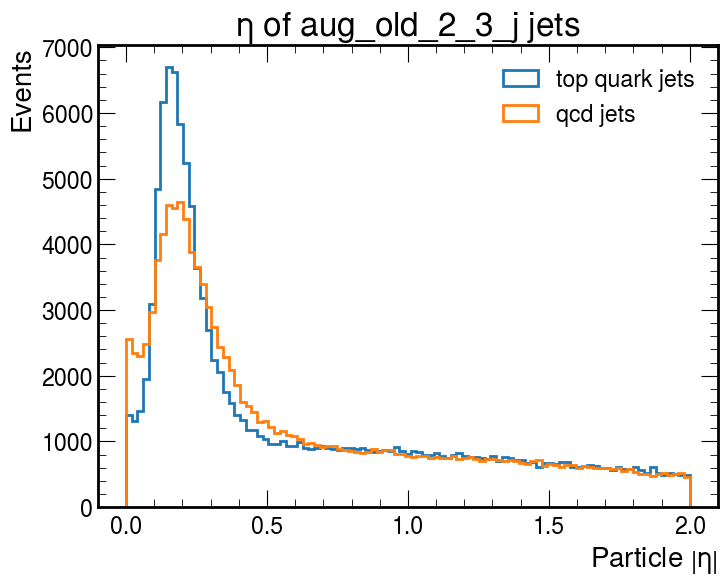

In [38]:
# which feature to look at?
feature = "eta"

index = feature_dict[feature]
print(f"feature {feature} corresponding to index {index}")

features = {}
features["top"] = []
features["qcd"] = []
for jet, class_label in tqdm(zip(aug_old_2_3_j, labels_3)):
    if class_label==1:
        label = "top"
    else:
        label = "qcd"
    
    for particle in jet.T:
        features[label].append(np.abs(particle[index]))
            
plt.rcParams.update({"font.size": 20})

fig, ax = plt.subplots(figsize=(8, 6))
plt.hist(features["top"], bins=np.linspace(0,2,100), histtype="step", linewidth=2, label=f"top quark jets")
plt.hist(features["qcd"], bins=np.linspace(0,2,100), histtype="step", linewidth=2, label=f"qcd jets")

ax.legend()
ax.set_xlabel(feature_label[feature]);
ax.set_ylabel(r"Events"); 
plt.title("$\eta$ of aug_old_2_3_j jets")
plt.savefig(f"{save_path}/eta_aug_old_2_3_j", bbox_inches='tight', dpi=300)
plt.show()          

feature eta corresponding to index 0


100001it [00:03, 25062.06it/s]


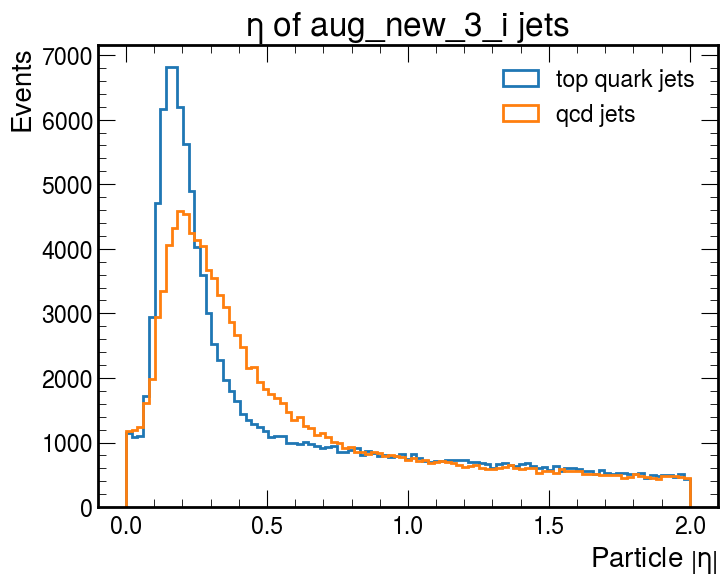

In [39]:
# which feature to look at?
feature = "eta"

index = feature_dict[feature]
print(f"feature {feature} corresponding to index {index}")

features = {}
features["top"] = []
features["qcd"] = []
for jet, class_label in tqdm(zip(aug_new_3_i, labels_3)):
    if class_label==1:
        label = "top"
    else:
        label = "qcd"
    
    for particle in jet.T:
        features[label].append(np.abs(particle[index]))
            
plt.rcParams.update({"font.size": 20})

fig, ax = plt.subplots(figsize=(8, 6))
plt.hist(features["top"], bins=np.linspace(0,2,100), histtype="step", linewidth=2, label=f"top quark jets")
plt.hist(features["qcd"], bins=np.linspace(0,2,100), histtype="step", linewidth=2, label=f"qcd jets")

ax.legend()
ax.set_xlabel(feature_label[feature]);
ax.set_ylabel(r"Events"); 
plt.title("$\eta$ of aug_new_3_i jets")
plt.savefig(f"{save_path}/eta_aug_new_3_i", bbox_inches='tight', dpi=300)
plt.show()          

feature eta corresponding to index 0


100001it [00:04, 24858.12it/s]


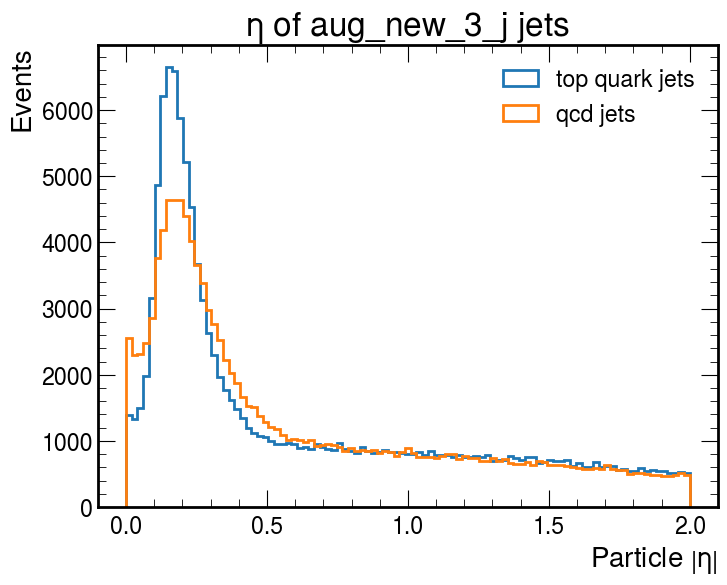

In [40]:
# which feature to look at?
feature = "eta"

index = feature_dict[feature]
print(f"feature {feature} corresponding to index {index}")

features = {}
features["top"] = []
features["qcd"] = []
for jet, class_label in tqdm(zip(aug_new_3_j, labels_3)):
    if class_label==1:
        label = "top"
    else:
        label = "qcd"
    
    for particle in jet.T:
        features[label].append(np.abs(particle[index]))
            
plt.rcParams.update({"font.size": 20})

fig, ax = plt.subplots(figsize=(8, 6))
plt.hist(features["top"], bins=np.linspace(0,2,100), histtype="step", linewidth=2, label=f"top quark jets")
plt.hist(features["qcd"], bins=np.linspace(0,2,100), histtype="step", linewidth=2, label=f"qcd jets")

ax.legend()
ax.set_xlabel(feature_label[feature]);
ax.set_ylabel(r"Events"); 
plt.title("$\eta$ of aug_new_3_j jets")
plt.savefig(f"{save_path}/eta_aug_new_3_j", bbox_inches='tight', dpi=300)
plt.show()          

feature eta corresponding to index 0


100001it [00:09, 10569.39it/s]


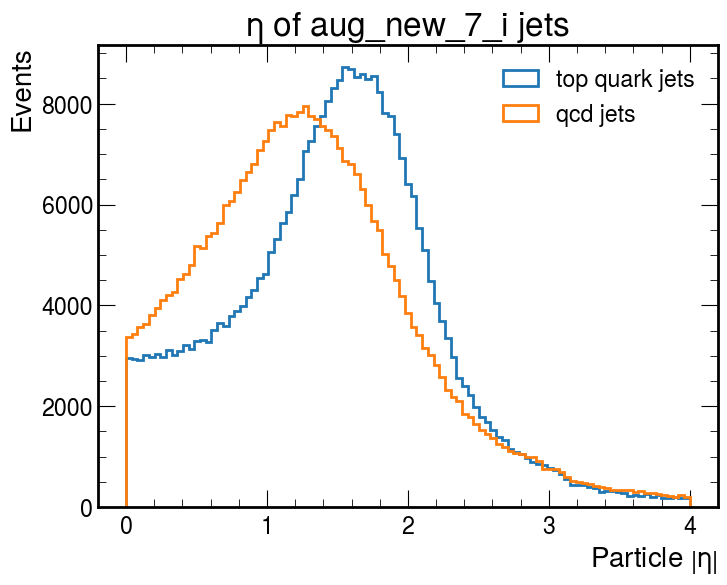

In [20]:
# which feature to look at?
feature = "eta"

index = feature_dict[feature]
print(f"feature {feature} corresponding to index {index}")

features = {}
features["top"] = []
features["qcd"] = []
for jet, class_label in tqdm(zip(aug_new_7_i, labels_3)):
    if class_label==1:
        label = "top"
    else:
        label = "qcd"
    
    for particle in jet.T:
        features[label].append(np.abs(particle[index]))
            
plt.rcParams.update({"font.size": 20})

fig, ax = plt.subplots(figsize=(8, 6))
plt.hist(features["top"], bins=np.linspace(0,4,100), histtype="step", linewidth=2, label=f"top quark jets")
plt.hist(features["qcd"], bins=np.linspace(0,4,100), histtype="step", linewidth=2, label=f"qcd jets")

ax.legend()
ax.set_xlabel(feature_label[feature]);
ax.set_ylabel(r"Events"); 
plt.title("$\eta$ of aug_new_7_i jets")
plt.savefig(f"{save_path}/eta_aug_new_7_i", bbox_inches='tight', dpi=300)
plt.show()          

feature eta corresponding to index 0


100001it [00:09, 11030.49it/s]


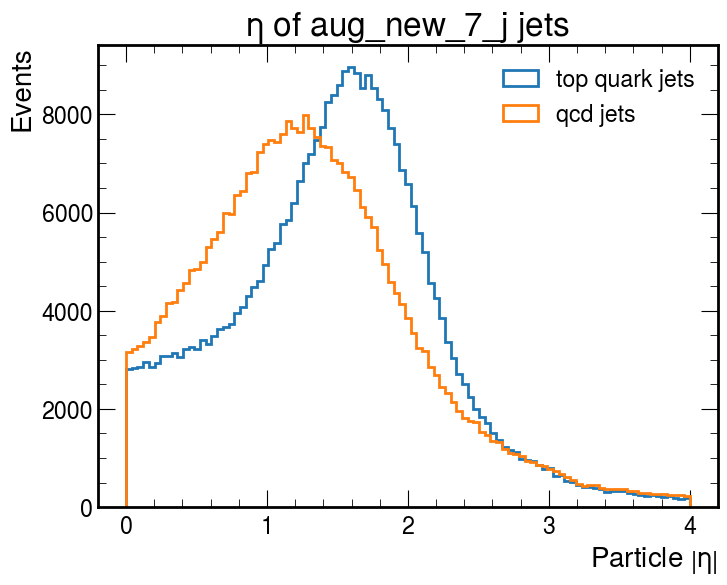

In [35]:
# which feature to look at?
feature = "eta"

index = feature_dict[feature]
print(f"feature {feature} corresponding to index {index}")

features = {}
features["top"] = []
features["qcd"] = []
for jet, class_label in tqdm(zip(aug_new_7_j, labels_3)):
    if class_label==1:
        label = "top"
    else:
        label = "qcd"
    
    for particle in jet.T:
        features[label].append(np.abs(particle[index]))
            
plt.rcParams.update({"font.size": 20})

fig, ax = plt.subplots(figsize=(8, 6))
plt.hist(features["top"], bins=np.linspace(0,4,100), histtype="step", linewidth=2, label=f"top quark jets")
plt.hist(features["qcd"], bins=np.linspace(0,4,100), histtype="step", linewidth=2, label=f"qcd jets")

ax.legend()
ax.set_xlabel(feature_label[feature]);
ax.set_ylabel(r"Events"); 
plt.title("$\eta$ of aug_new_7_j jets")
plt.savefig(f"{save_path}/eta_aug_new_7_j", bbox_inches='tight', dpi=300)
plt.show()          

## Phi

In [43]:
save_path = "../plots/examine-augmentations/phi/i"
os.system(f"mkdir -p {save_path}")  # -p: create parent dirs if needed, exist_ok

0

feature phi corresponding to index 1


100001it [00:04, 24500.98it/s]


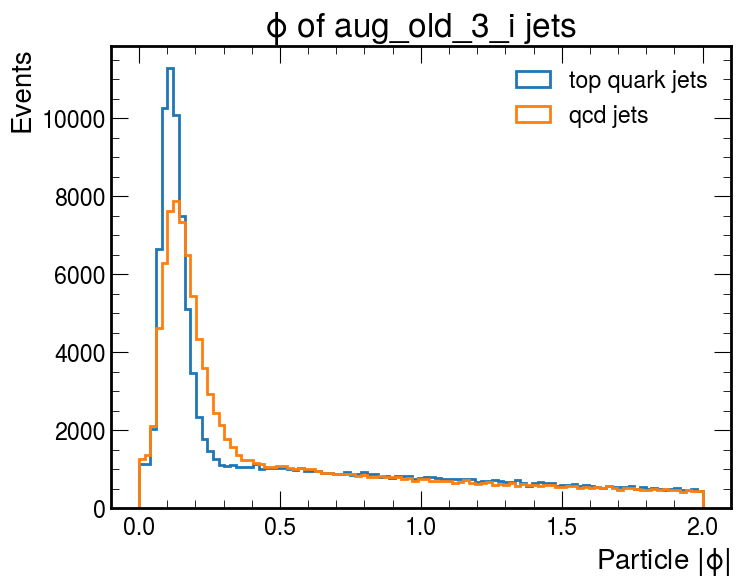

In [44]:
# which feature to look at?
feature = "phi"

index = feature_dict[feature]
print(f"feature {feature} corresponding to index {index}")

features = {}
features["top"] = []
features["qcd"] = []
for jet, class_label in tqdm(zip(aug_old_3_i, labels_3)):
    if class_label==1:
        label = "top"
    else:
        label = "qcd"
    
    for particle in jet.T:
        features[label].append(np.abs(particle[index]))
            
plt.rcParams.update({"font.size": 20})

fig, ax = plt.subplots(figsize=(8, 6))
plt.hist(features["top"], bins=np.linspace(0,2,100), histtype="step", linewidth=2, label=f"top quark jets")
plt.hist(features["qcd"], bins=np.linspace(0,2,100), histtype="step", linewidth=2, label=f"qcd jets")

ax.legend()
ax.set_xlabel(feature_label[feature]);
ax.set_ylabel(r"Events"); 
plt.title("$\phi$ of aug_old_3_i jets")
plt.savefig(f"{save_path}/phi_aug_old_3_i", bbox_inches='tight', dpi=300)
plt.show()          

feature phi corresponding to index 1


100001it [00:04, 24339.84it/s]


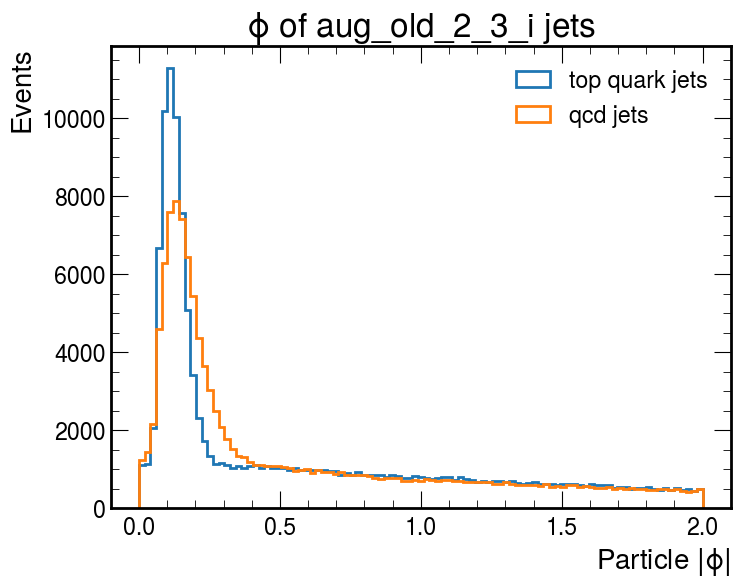

In [45]:
# which feature to look at?
feature = "phi"

index = feature_dict[feature]
print(f"feature {feature} corresponding to index {index}")

features = {}
features["top"] = []
features["qcd"] = []
for jet, class_label in tqdm(zip(aug_old_2_3_i, labels_3)):
    if class_label==1:
        label = "top"
    else:
        label = "qcd"
    
    for particle in jet.T:
        features[label].append(np.abs(particle[index]))
            
plt.rcParams.update({"font.size": 20})

fig, ax = plt.subplots(figsize=(8, 6))
plt.hist(features["top"], bins=np.linspace(0,2,100), histtype="step", linewidth=2, label=f"top quark jets")
plt.hist(features["qcd"], bins=np.linspace(0,2,100), histtype="step", linewidth=2, label=f"qcd jets")

ax.legend()
ax.set_xlabel(feature_label[feature]);
ax.set_ylabel(r"Events"); 
plt.title("$\phi$ of aug_old_2_3_i jets")
plt.savefig(f"{save_path}/phi_aug_old_2_3_i", bbox_inches='tight', dpi=300)
plt.show()          

feature phi corresponding to index 1


100001it [00:03, 25925.75it/s]


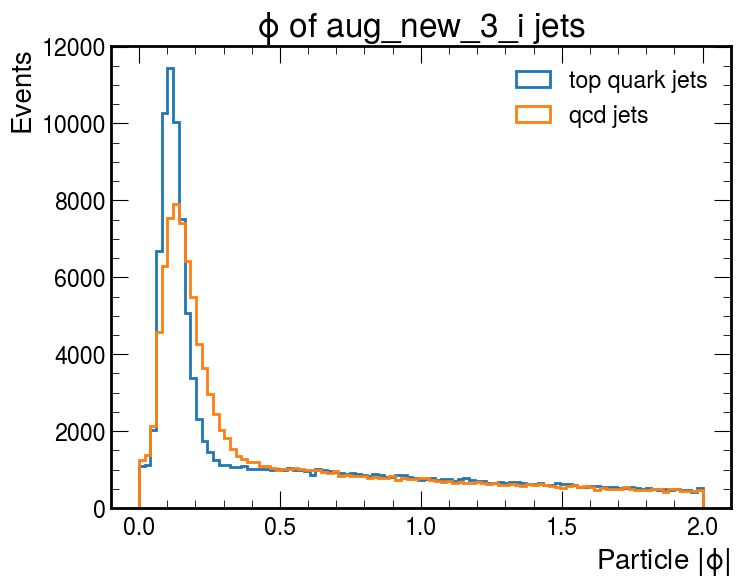

In [46]:
# which feature to look at?
feature = "phi"

index = feature_dict[feature]
print(f"feature {feature} corresponding to index {index}")

features = {}
features["top"] = []
features["qcd"] = []
for jet, class_label in tqdm(zip(aug_new_3_i, labels_3)):
    if class_label==1:
        label = "top"
    else:
        label = "qcd"
    
    for particle in jet.T:
        features[label].append(np.abs(particle[index]))
            
plt.rcParams.update({"font.size": 20})

fig, ax = plt.subplots(figsize=(8, 6))
plt.hist(features["top"], bins=np.linspace(0,2,100), histtype="step", linewidth=2, label=f"top quark jets")
plt.hist(features["qcd"], bins=np.linspace(0,2,100), histtype="step", linewidth=2, label=f"qcd jets")

ax.legend()
ax.set_xlabel(feature_label[feature]);
ax.set_ylabel(r"Events"); 
plt.title("$\phi$ of aug_new_3_i jets")
plt.savefig(f"{save_path}/phi_aug_new_3_i", bbox_inches='tight', dpi=300)
plt.show()          

feature phi corresponding to index 1


100001it [00:09, 10938.34it/s]


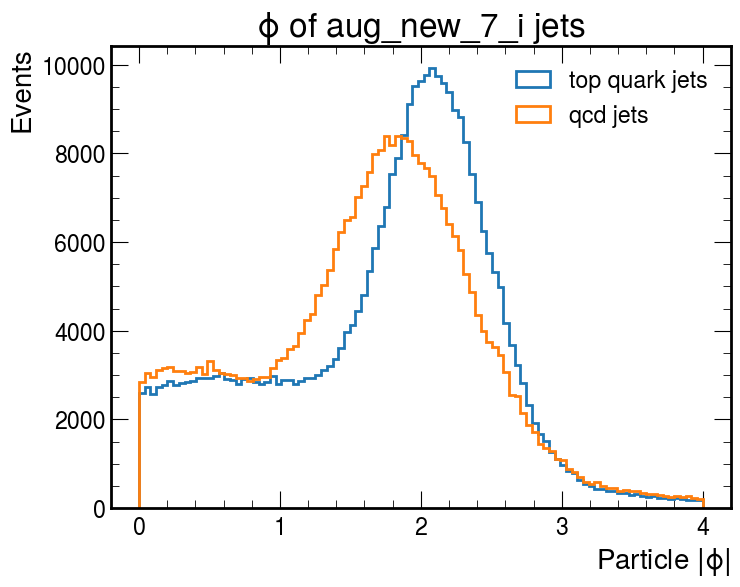

In [38]:
# which feature to look at?
feature = "phi"

index = feature_dict[feature]
print(f"feature {feature} corresponding to index {index}")

features = {}
features["top"] = []
features["qcd"] = []
for jet, class_label in tqdm(zip(aug_new_7_i, labels_3)):
    if class_label==1:
        label = "top"
    else:
        label = "qcd"
    
    for particle in jet.T:
        features[label].append(np.abs(particle[index]))
            
plt.rcParams.update({"font.size": 20})

fig, ax = plt.subplots(figsize=(8, 6))
plt.hist(features["top"], bins=np.linspace(0,4,100), histtype="step", linewidth=2, label=f"top quark jets")
plt.hist(features["qcd"], bins=np.linspace(0,4,100), histtype="step", linewidth=2, label=f"qcd jets")

ax.legend()
ax.set_xlabel(feature_label[feature]);
ax.set_ylabel(r"Events"); 
plt.title("$\phi$ of aug_new_7_i jets")
plt.savefig(f"{save_path}/phi_aug_new_7_i", bbox_inches='tight', dpi=300)
plt.show()          

### --------------------------------------------------------------------------------------------------------------

In [48]:
save_path = "../plots/examine-augmentations/phi/j"
os.system(f"mkdir -p {save_path}")  # -p: create parent dirs if needed, exist_ok

0

feature phi corresponding to index 1


100001it [00:04, 24992.27it/s]


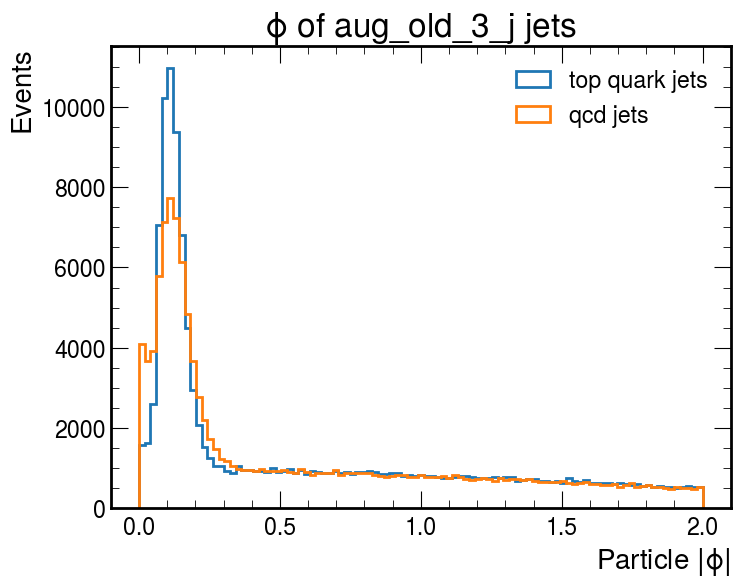

In [49]:
# which feature to look at?
feature = "phi"

index = feature_dict[feature]
print(f"feature {feature} corresponding to index {index}")

features = {}
features["top"] = []
features["qcd"] = []
for jet, class_label in tqdm(zip(aug_old_3_j, labels_3)):
    if class_label==1:
        label = "top"
    else:
        label = "qcd"
    
    for particle in jet.T:
        features[label].append(np.abs(particle[index]))
            
plt.rcParams.update({"font.size": 20})

fig, ax = plt.subplots(figsize=(8, 6))
plt.hist(features["top"], bins=np.linspace(0,2,100), histtype="step", linewidth=2, label=f"top quark jets")
plt.hist(features["qcd"], bins=np.linspace(0,2,100), histtype="step", linewidth=2, label=f"qcd jets")

ax.legend()
ax.set_xlabel(feature_label[feature]);
ax.set_ylabel(r"Events"); 
plt.title("$\phi$ of aug_old_3_j jets")
plt.savefig(f"{save_path}/phi_aug_old_3_j", bbox_inches='tight', dpi=300)
plt.show()          

feature phi corresponding to index 1


100001it [00:04, 24950.24it/s]


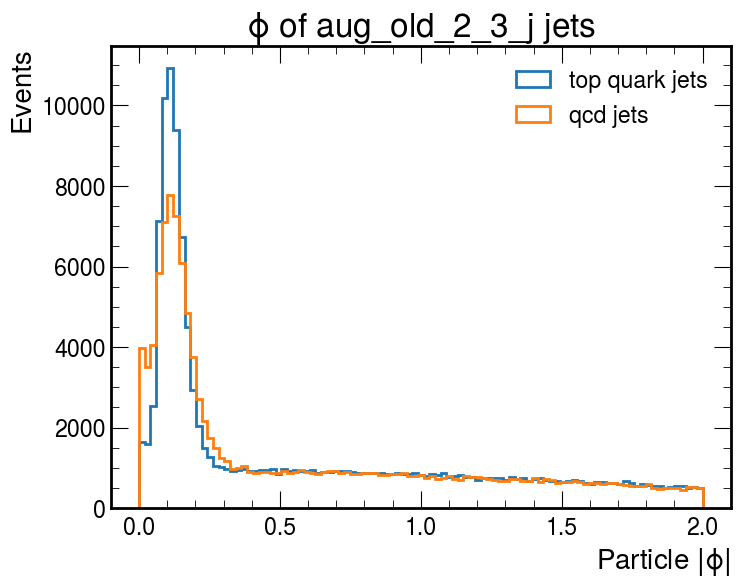

In [50]:
# which feature to look at?
feature = "phi"

index = feature_dict[feature]
print(f"feature {feature} corresponding to index {index}")

features = {}
features["top"] = []
features["qcd"] = []
for jet, class_label in tqdm(zip(aug_old_2_3_j, labels_3)):
    if class_label==1:
        label = "top"
    else:
        label = "qcd"
    
    for particle in jet.T:
        features[label].append(np.abs(particle[index]))
            
plt.rcParams.update({"font.size": 20})

fig, ax = plt.subplots(figsize=(8, 6))
plt.hist(features["top"], bins=np.linspace(0,2,100), histtype="step", linewidth=2, label=f"top quark jets")
plt.hist(features["qcd"], bins=np.linspace(0,2,100), histtype="step", linewidth=2, label=f"qcd jets")

ax.legend()
ax.set_xlabel(feature_label[feature]);
ax.set_ylabel(r"Events"); 
plt.title("$\phi$ of aug_old_2_3_j jets")
plt.savefig(f"{save_path}/phi_aug_old_2_3_j", bbox_inches='tight', dpi=300)
plt.show()          

feature phi corresponding to index 1


100001it [00:03, 26076.74it/s]


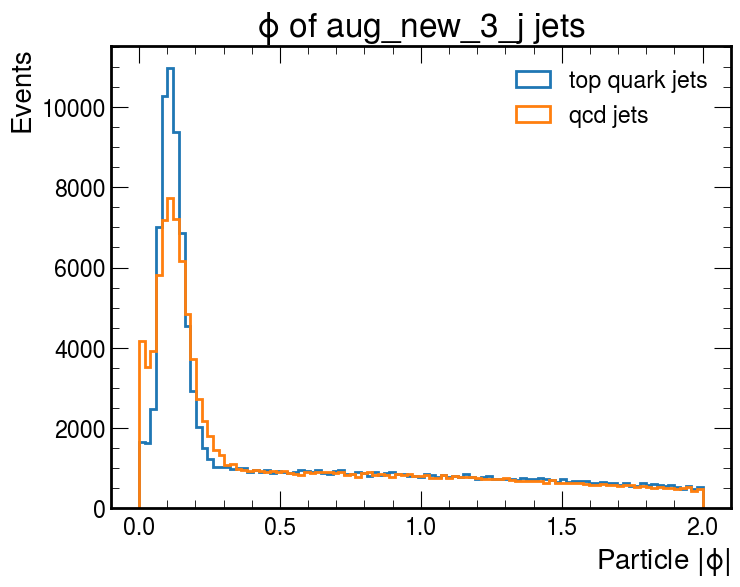

In [51]:
# which feature to look at?
feature = "phi"

index = feature_dict[feature]
print(f"feature {feature} corresponding to index {index}")

features = {}
features["top"] = []
features["qcd"] = []
for jet, class_label in tqdm(zip(aug_new_3_j, labels_3)):
    if class_label==1:
        label = "top"
    else:
        label = "qcd"
    
    for particle in jet.T:
        features[label].append(np.abs(particle[index]))
            
plt.rcParams.update({"font.size": 20})

fig, ax = plt.subplots(figsize=(8, 6))
plt.hist(features["top"], bins=np.linspace(0,2,100), histtype="step", linewidth=2, label=f"top quark jets")
plt.hist(features["qcd"], bins=np.linspace(0,2,100), histtype="step", linewidth=2, label=f"qcd jets")

ax.legend()
ax.set_xlabel(feature_label[feature]);
ax.set_ylabel(r"Events"); 
plt.title("$\phi$ of aug_new_3_j jets")
plt.savefig(f"{save_path}/phi_aug_new_3_j", bbox_inches='tight', dpi=300)
plt.show()          

feature phi corresponding to index 1


100001it [00:09, 10772.55it/s]


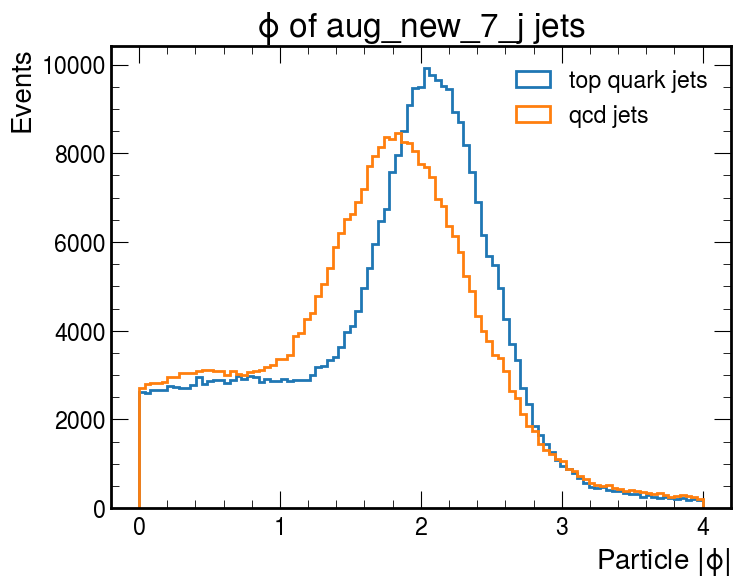

In [39]:
# which feature to look at?
feature = "phi"

index = feature_dict[feature]
print(f"feature {feature} corresponding to index {index}")

features = {}
features["top"] = []
features["qcd"] = []
for jet, class_label in tqdm(zip(aug_new_7_j, labels_3)):
    if class_label==1:
        label = "top"
    else:
        label = "qcd"
    
    for particle in jet.T:
        features[label].append(np.abs(particle[index]))
            
plt.rcParams.update({"font.size": 20})

fig, ax = plt.subplots(figsize=(8, 6))
plt.hist(features["top"], bins=np.linspace(0,4,100), histtype="step", linewidth=2, label=f"top quark jets")
plt.hist(features["qcd"], bins=np.linspace(0,4,100), histtype="step", linewidth=2, label=f"qcd jets")

ax.legend()
ax.set_xlabel(feature_label[feature]);
ax.set_ylabel(r"Events"); 
plt.title("$\phi$ of aug_new_7_j jets")
plt.savefig(f"{save_path}/phi_aug_new_7_j", bbox_inches='tight', dpi=300)
plt.show()          

## pT

In [53]:
save_path = "../plots/examine-augmentations/pT/i"
os.system(f"mkdir -p {save_path}")  # -p: create parent dirs if needed, exist_ok

0

feature pt corresponding to index 2


100001it [00:04, 22478.44it/s]


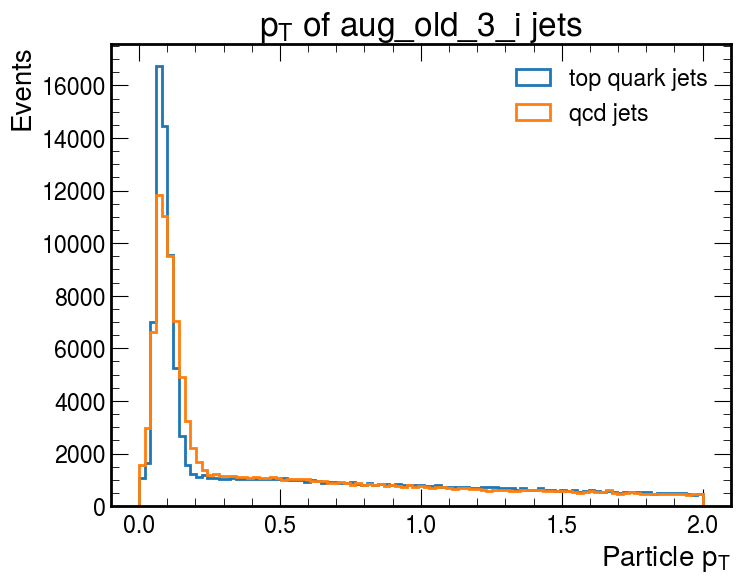

In [55]:
# which feature to look at?
feature = "pt"

index = feature_dict[feature]
print(f"feature {feature} corresponding to index {index}")

features = {}
features["top"] = []
features["qcd"] = []
for jet, class_label in tqdm(zip(aug_old_3_i, labels_3)):
    if class_label==1:
        label = "top"
    else:
        label = "qcd"
    
    for particle in jet.T:
        features[label].append(np.abs(particle[index]))
            
plt.rcParams.update({"font.size": 20})

fig, ax = plt.subplots(figsize=(8, 6))
plt.hist(features["top"], bins=np.linspace(0,2,100), histtype="step", linewidth=2, label=f"top quark jets")
plt.hist(features["qcd"], bins=np.linspace(0,2,100), histtype="step", linewidth=2, label=f"qcd jets")

ax.legend()
ax.set_xlabel(feature_label[feature]);
ax.set_ylabel(r"Events"); 
plt.title("$p_T$ of aug_old_3_i jets")
plt.savefig(f"{save_path}/pT_aug_old_3_i", bbox_inches='tight', dpi=300)
plt.show()          

feature pt corresponding to index 2


100001it [00:04, 23360.64it/s]


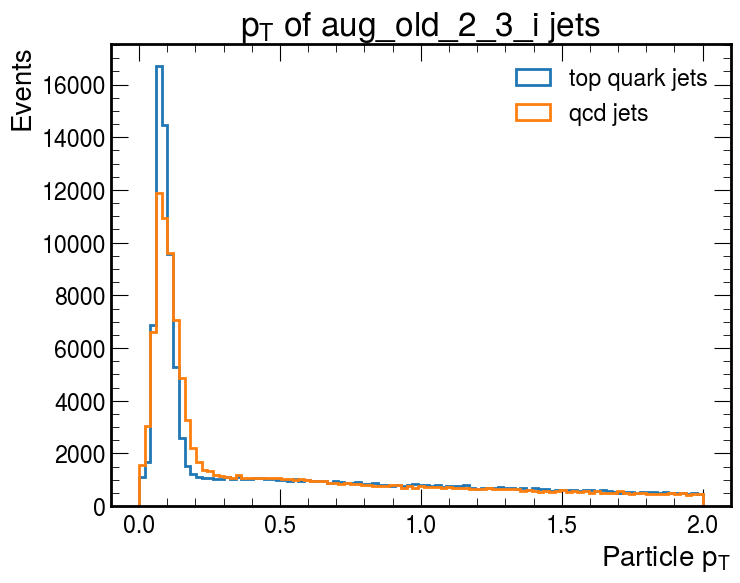

In [56]:
# which feature to look at?
feature = "pt"

index = feature_dict[feature]
print(f"feature {feature} corresponding to index {index}")

features = {}
features["top"] = []
features["qcd"] = []
for jet, class_label in tqdm(zip(aug_old_2_3_i, labels_3)):
    if class_label==1:
        label = "top"
    else:
        label = "qcd"
    
    for particle in jet.T:
        features[label].append(np.abs(particle[index]))
            
plt.rcParams.update({"font.size": 20})

fig, ax = plt.subplots(figsize=(8, 6))
plt.hist(features["top"], bins=np.linspace(0,2,100), histtype="step", linewidth=2, label=f"top quark jets")
plt.hist(features["qcd"], bins=np.linspace(0,2,100), histtype="step", linewidth=2, label=f"qcd jets")

ax.legend()
ax.set_xlabel(feature_label[feature]);
ax.set_ylabel(r"Events"); 
plt.title("$p_T$ of aug_old_2_3_i jets")
plt.savefig(f"{save_path}/pT_aug_old_2_3_i", bbox_inches='tight', dpi=300)
plt.show()          

feature pt corresponding to index 2


100001it [00:04, 23172.60it/s]


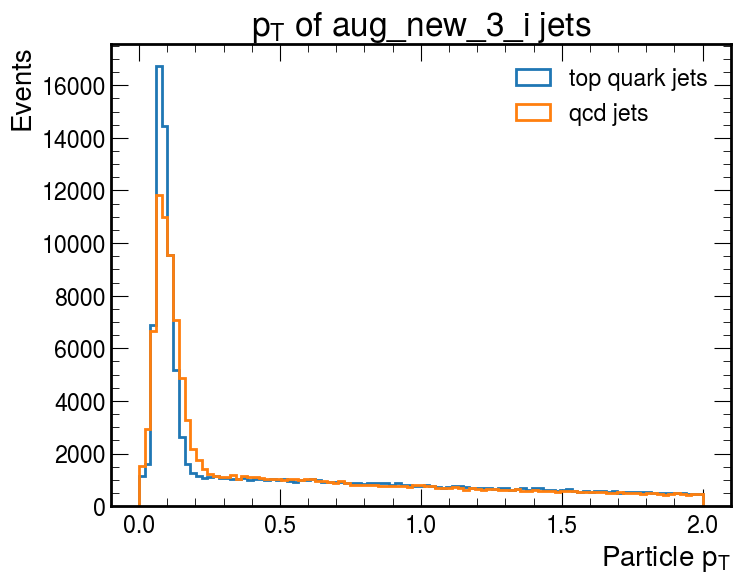

In [57]:
# which feature to look at?
feature = "pt"

index = feature_dict[feature]
print(f"feature {feature} corresponding to index {index}")

features = {}
features["top"] = []
features["qcd"] = []
for jet, class_label in tqdm(zip(aug_new_3_i, labels_3)):
    if class_label==1:
        label = "top"
    else:
        label = "qcd"
    
    for particle in jet.T:
        features[label].append(np.abs(particle[index]))
            
plt.rcParams.update({"font.size": 20})

fig, ax = plt.subplots(figsize=(8, 6))
plt.hist(features["top"], bins=np.linspace(0,2,100), histtype="step", linewidth=2, label=f"top quark jets")
plt.hist(features["qcd"], bins=np.linspace(0,2,100), histtype="step", linewidth=2, label=f"qcd jets")

ax.legend()
ax.set_xlabel(feature_label[feature]);
ax.set_ylabel(r"Events"); 
plt.title("$p_T$ of aug_new_3_i jets")
plt.savefig(f"{save_path}/pT_aug_new_3_i", bbox_inches='tight', dpi=300)
plt.show()          

feature pt corresponding to index 0


100001it [00:10, 9950.23it/s]


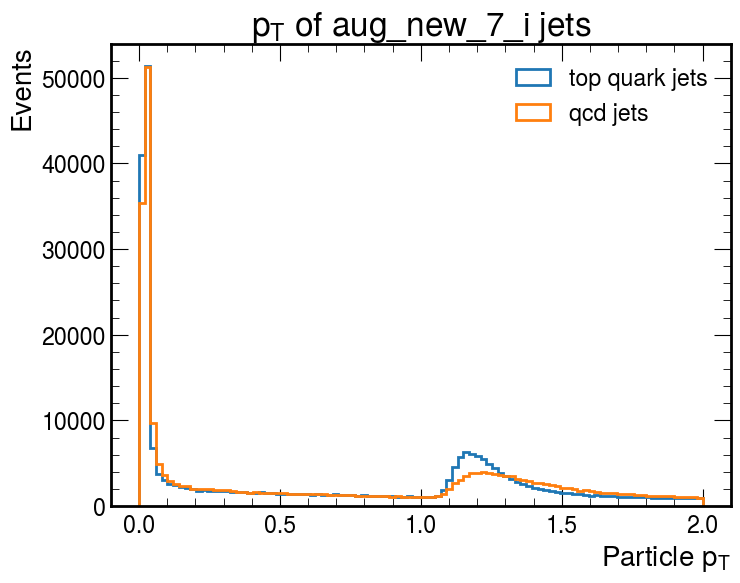

In [21]:
# which feature to look at?
feature = "pt"

index = feature_dict[feature]
print(f"feature {feature} corresponding to index {index}")

features = {}
features["top"] = []
features["qcd"] = []
for jet, class_label in tqdm(zip(aug_new_7_i, labels_3)):
    if class_label==1:
        label = "top"
    else:
        label = "qcd"
    
    for particle in jet.T:
        features[label].append(np.exp(particle[index]))
            
plt.rcParams.update({"font.size": 20})

fig, ax = plt.subplots(figsize=(8, 6))
plt.hist(features["top"], bins=np.linspace(0,2,100), histtype="step", linewidth=2, label=f"top quark jets")
plt.hist(features["qcd"], bins=np.linspace(0,2,100), histtype="step", linewidth=2, label=f"qcd jets")

ax.legend()
ax.set_xlabel(feature_label[feature]);
ax.set_ylabel(r"Events"); 
plt.title("$p_T$ of aug_new_7_i jets")
plt.savefig(f"{save_path}/pT_aug_new_7_i", bbox_inches='tight', dpi=300)
plt.show()          

In [59]:
save_path = "../plots/examine-augmentations/pT/j"
os.system(f"mkdir -p {save_path}")  # -p: create parent dirs if needed, exist_ok

0

feature pt corresponding to index 2


100001it [00:04, 23749.34it/s]


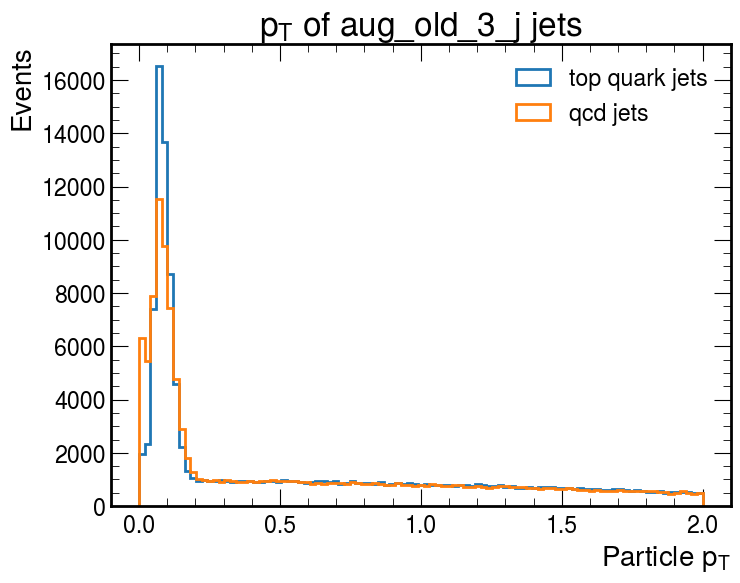

In [60]:
# which feature to look at?
feature = "pt"

index = feature_dict[feature]
print(f"feature {feature} corresponding to index {index}")

features = {}
features["top"] = []
features["qcd"] = []
for jet, class_label in tqdm(zip(aug_old_3_j, labels_3)):
    if class_label==1:
        label = "top"
    else:
        label = "qcd"
    
    for particle in jet.T:
        features[label].append(np.abs(particle[index]))
            
plt.rcParams.update({"font.size": 20})

fig, ax = plt.subplots(figsize=(8, 6))
plt.hist(features["top"], bins=np.linspace(0,2,100), histtype="step", linewidth=2, label=f"top quark jets")
plt.hist(features["qcd"], bins=np.linspace(0,2,100), histtype="step", linewidth=2, label=f"qcd jets")

ax.legend()
ax.set_xlabel(feature_label[feature]);
ax.set_ylabel(r"Events"); 
plt.title("$p_T$ of aug_old_3_j jets")
plt.savefig(f"{save_path}/pT_aug_old_3_j", bbox_inches='tight', dpi=300)
plt.show()          

feature pt corresponding to index 2


100001it [00:04, 23104.25it/s]


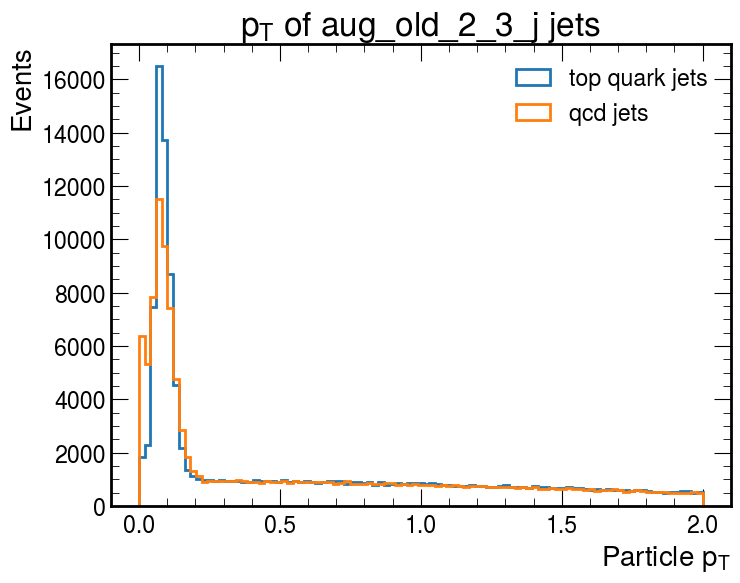

In [61]:
# which feature to look at?
feature = "pt"

index = feature_dict[feature]
print(f"feature {feature} corresponding to index {index}")

features = {}
features["top"] = []
features["qcd"] = []
for jet, class_label in tqdm(zip(aug_old_2_3_j, labels_3)):
    if class_label==1:
        label = "top"
    else:
        label = "qcd"
    
    for particle in jet.T:
        features[label].append(np.abs(particle[index]))
            
plt.rcParams.update({"font.size": 20})

fig, ax = plt.subplots(figsize=(8, 6))
plt.hist(features["top"], bins=np.linspace(0,2,100), histtype="step", linewidth=2, label=f"top quark jets")
plt.hist(features["qcd"], bins=np.linspace(0,2,100), histtype="step", linewidth=2, label=f"qcd jets")

ax.legend()
ax.set_xlabel(feature_label[feature]);
ax.set_ylabel(r"Events"); 
plt.title("$p_T$ of aug_old_2_3_j jets")
plt.savefig(f"{save_path}/pT_aug_old_2_3_j", bbox_inches='tight', dpi=300)
plt.show()          

feature pt corresponding to index 2


100001it [00:04, 22292.52it/s]


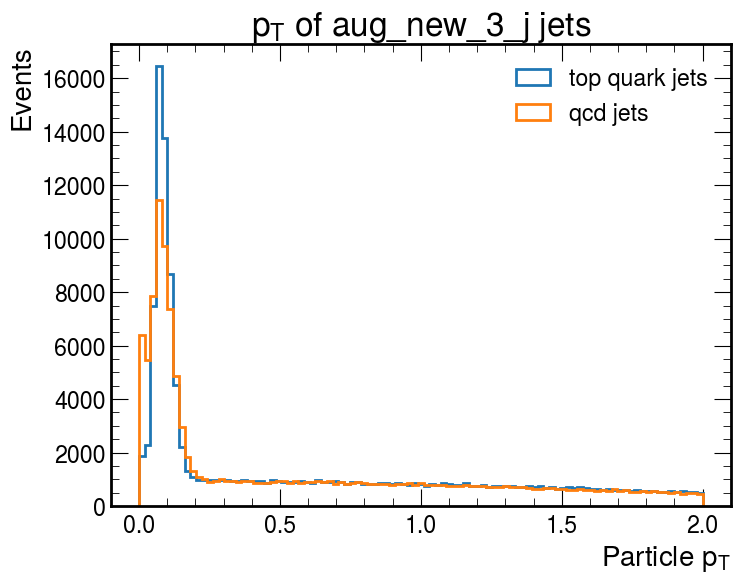

In [62]:
# which feature to look at?
feature = "pt"

index = feature_dict[feature]
print(f"feature {feature} corresponding to index {index}")

features = {}
features["top"] = []
features["qcd"] = []
for jet, class_label in tqdm(zip(aug_new_3_j, labels_3)):
    if class_label==1:
        label = "top"
    else:
        label = "qcd"
    
    for particle in jet.T:
        features[label].append(np.abs(particle[index]))
            
plt.rcParams.update({"font.size": 20})

fig, ax = plt.subplots(figsize=(8, 6))
plt.hist(features["top"], bins=np.linspace(0,2,100), histtype="step", linewidth=2, label=f"top quark jets")
plt.hist(features["qcd"], bins=np.linspace(0,2,100), histtype="step", linewidth=2, label=f"qcd jets")

ax.legend()
ax.set_xlabel(feature_label[feature]);
ax.set_ylabel(r"Events"); 
plt.title("$p_T$ of aug_new_3_j jets")
plt.savefig(f"{save_path}/pT_aug_new_3_j", bbox_inches='tight', dpi=300)
plt.show()          

feature pt corresponding to index 2


100001it [00:09, 10892.46it/s]


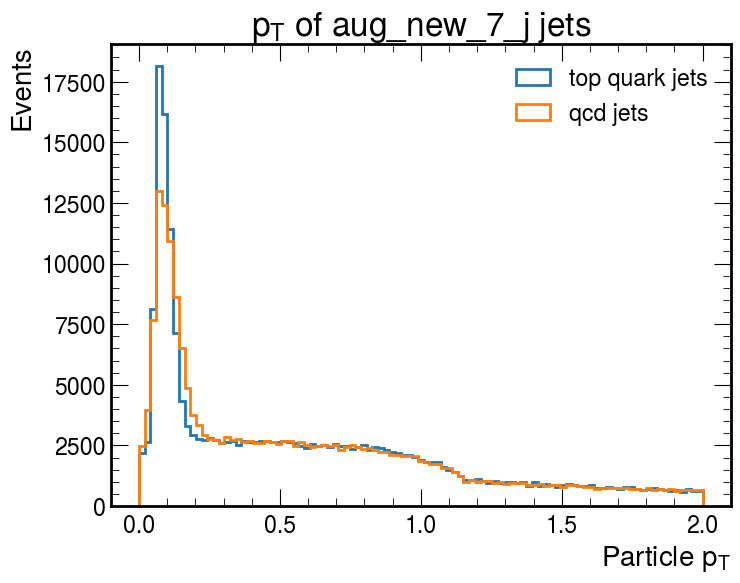

In [63]:
# which feature to look at?
feature = "pt"

index = feature_dict[feature]
print(f"feature {feature} corresponding to index {index}")

features = {}
features["top"] = []
features["qcd"] = []
for jet, class_label in tqdm(zip(aug_new_7_j, labels_3)):
    if class_label==1:
        label = "top"
    else:
        label = "qcd"
    
    for particle in jet.T:
        features[label].append(np.abs(particle[index]))
            
plt.rcParams.update({"font.size": 20})

fig, ax = plt.subplots(figsize=(8, 6))
plt.hist(features["top"], bins=np.linspace(0,2,100), histtype="step", linewidth=2, label=f"top quark jets")
plt.hist(features["qcd"], bins=np.linspace(0,2,100), histtype="step", linewidth=2, label=f"qcd jets")

ax.legend()
ax.set_xlabel(feature_label[feature]);
ax.set_ylabel(r"Events"); 
plt.title("$p_T$ of aug_new_7_j jets")
plt.savefig(f"{save_path}/pT_aug_new_7_j", bbox_inches='tight', dpi=300)
plt.show()          